In [13]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [14]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [15]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [16]:
qfl_factors = qfl_management # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [17]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [18]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [19]:
qfl_df = df

In [22]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,5YR_FWD)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,CT)","QFL_EPS_MGMT(0,5YR)","QFL_EPS_MGMT(0,4YR)","QFL_EPS_MGMT(0,3YR)","QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)","QFL_GP_RD(0,CT)","QFL_GP_RD(0,FY1)","QFL_GP_RD(0,FY2)",QFL_SOE_OPER_INC(0),QFL_SOE_NI(0)
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,14.232402,1.695430,-1.707381,-6.487602,-6.769890,-6.166559,18.641983,16.383162,8.334882,0.674282,0.323057,-3.274627,-12.585688,-17.143047,-25.134813,-27.651560,-37.684650,0.067768,2.301311,9.811879,24.030650,50.918533,4.721322,11.385763,5.804861,0.231421,4.306352,12.432742,NaN,NaN,NaN,0.000000,0.000000,-5.634582,-5.634582,-5.999499,-6.356990,-5.954141,-4.802382,5.306195,6.001890,6.001890,6.226742,6.916022,6.811154,6.040931,NaN,NaN,0.661089,0.901729,0.902168,0.899589,NaN,NaN,NaN,NaN,NaN
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,10.506919,11.064434,8.155799,7.002950,8.520770,9.004652,NaN,NaN,10.148942,9.147401,8.306876,15.733818,21.386242,24.667858,20.944489,19.020473,51.222800,NaN,NaN,12.200121,16.039371,22.062477,5.252995,12.079012,-0.082612,-2.046847,-2.550513,-4.867434,NaN,NaN,0.106457,0.177492,0.355299,-0.819236,-0.819236,-0.591624,-0.664943,-0.862533,-0.942332,1.770622,1.638246,1.638246,1.411974,1.669562,1.236820,1.065230,8.056472,0.745058,1.360305,1.593058,1.622348,1.557732,NaN,NaN,NaN,NaN,NaN
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,25.321291,38.589787,39.131737,34.145237,36.652040,39.623760,21.917560,22.079683,22.007670,25.596766,33.420467,20.962788,45.255684,43.213417,41.731430,78.630830,127.306010,14.852304,21.782967,27.358932,42.731700,111.827660,25.551268,47.610428,50.443413,34.597755,39.550900,30.370104,NaN,NaN,8.919565,17.703426,40.639690,1.408195,1.408195,1.418483,1.365161,1.279020,1.185274,0.000000,-2.608132,-2.608132,-2.378261,-1.907575,-1.069260,-1.884329,14.437173,1.400128,1.286771,0.974764,1.203026,0.957236,NaN,NaN,NaN,NaN,NaN
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,19.940973,26.453436,25.269270,24.391794,26.472950,16.051388,18.270350,19.277893,22.169395,22.172838,19.467426,16.395721,44.034256,37.877083,18.353440,-3.090429,-5.590177,9.230174,11.677859,15.541223,17.412542,4.697917,72.560680,72.560680,121.162674,886.410030,667.699800,12.734282,NaN,NaN,NaN,NaN,NaN,-0.173599,-0.173599,-0.566298,-0.689107,-0.212008,-0.145960,1.057473,0.007308,0.007308,0.345075,1.239991,1.092124,-0.020278,7.894865,0.795314,2.257925,2.459521,2.283508,2.472958,NaN,NaN,NaN,NaN,NaN
4,890100,30-Nov-2020,02079K10,1.085045,

In [23]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,5YR_FWD)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,CT)","QFL_EPS_MGMT(0,5YR)","QFL_EPS_MGMT(0,4YR)","QFL_EPS_MGMT(0,3YR)","QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)","QFL_GP_RD(0,CT)","QFL_GP_RD(0,FY1)","QFL_GP_RD(0,FY2)",QFL_SOE_OPER_INC(0),QFL_SOE_NI(0)
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,3.317663,3.945732,3.606510,2.025211,4.128361,4.488623,NaN,NaN,2.884123,3.391719,6.251077,16.722965,16.722965,3.773975,-23.663473,-79.392426,-83.468540,NaN,NaN,NaN,NaN,NaN,4.637395,3.809726,3.896999,2.775145,8.426559,17.990685,NaN,NaN,5.261423,6.024523,11.235206,2.577853,2.577853,3.017116,3.331697,2.157223,0.929046,0.000024,-2.733636,-2.733636,-2.393150,-2.543879,-2.254099,-0.656694,0.026437,0.001716,0.155303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,2.390451,6.243837,5.537581,4.987538,2.006042,7.195568,1.034630,1.503532,2.759877,4.100377,7.532526,0.091659,-6.810964,-3.959472,-5.557492,-9.314513,35.419020,NaN,NaN,5.539036,9.401146,19.686108,-3.200066,-3.200066,-3.736264,2.901316,-4.341531,-16.886170,NaN,NaN,NaN,NaN,NaN,-0.226289,-0.226289,-0.332946,-0.506794,-0.738138,0.020027,0.663988,0.173682,0.173682,0.203198,0.399899,1.051211,0.918639,NaN,NaN,1.069222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,0.316402,4.267192,1.699686,-1.894361,-3.588629,-7.321489,NaN,NaN,-2.410725,-2.490597,0.305862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108513,5.203032,4.647887,3.171575,4.799330,-7.184422,NaN,NaN,-3.732547,-0.421633,4.195699,-1.598000,-1.598000,-3.727269,-5.940616,-7.868922,-0.044692,-0.105474,-0.055313,-0.055313,0.684613,3.150809,6.172967,3.680629,0.054340,0.012481,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,1.678452,9.568810,9.855270,6.511712,-1.197004,-10.254580,-1.097785,-0.372007,-1.915402,-4.502726,-9.744802,8.015251,14.152123,23.911533,27.384170,25.490784,-4.765409,5.810906,4.34873,2.428124,-4.906968,-41.469105,38.961150,86.794160,112.860634,146.438460,62.701690,152.392070,NaN,16.898542,18.416428,33.519520,99.271470,7.519197,7.519197,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.729920,1.178150,0.896074,1.310575,NaN,NaN,NaN,NaN,NaN
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,3.457489,3.122139,2.581084,1.864314,2.009237,1.298213,3.548887,3.770274,3.962881,4.853523,6.632484,-2.392348,-6.909469,-0.126294,-1.016513,7.3539

In [24]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,5YR_FWD)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,CT)","QFL_EPS_MGMT(0,5YR)","QFL_EPS_MGMT(0,4YR)","QFL_EPS_MGMT(0,3YR)","QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)","QFL_GP_RD(0,CT)","QFL_GP_RD(0,FY1)","QFL_GP_RD(0,FY2)",QFL_SOE_OPER_INC(0),QFL_SOE_NI(0)
count,1600.0,1600.000000,1597.000000,1.598000e+03,1596.000000,1542.000000,1561.000000,1582.000000,1592.000000,1594.000000,565.000000,791.000000,1439.000000,1483.000000,1485.000000,1562.000000,1498.000000,1522.000000,1544.000000,1553.000000,1551.000000,664.000000,884.000000,1328.000000,1349.000000,1348.000000,1580.000000,1480.000000,1513.000000,1529.000000,1534.000000,1575.000000,292.000000,406.000000,925.000000,1018.000000,1021.000000,1592.000000,1521.000000,1537.000000,1552.000000,1567.000000,1592.000000,1594.000000,1451.000000,1337.000000,1312.000000,1379.000000,1402.000000,1406.000000,1073.000000,1032.000000,1582.000000,1349.000000,1349.000000,1346.000000,1.0,1.0,1.0,1.0,1.0
mean,890100.0,0.062500,3.118575,3.489420e+04,7.275138,9.669763,10.272980,10.168001,11.579942,11.698140,5.434839,5.503628,5.706014,6.935784,10.720627,5.734352,7.244669,7.718151,6.409479,4.363414,20.898750,2.876899,3.137674,3.413604,6.783277,29.843826,15.238524,16.066061,24.028121,29.711022,47.995591,52.502020,-0.071354,0.938140,2.412705,5.597758,20.623641,0.997673,0.896959,0.728290,0.686517,0.736215,1.720606,0.364842,-0.612662,-0.473691,-0.442475,-0.317362,0.338946,1.663174,5.779328,0.882873,1.688518,2.133629,5.186336,1.977430,0.0,0.0,0.0,0.0,0.0
std,0.0,0.177252,7.256757,9.150908e+04,11.380236,15.580940,18.996352,20.085274,25.786218,32.168174,7.016764,8.156276,8.152702,11.233636,24.126591,29.688620,19.403306,21.165828,28.140280,50.190706,421.781796,11.731236,12.890708,16.745234,59.692805,488.372810,65.830334,35.960964,104.524697,91.837601,292.306548,327.793125,12.180756,13.591500,14.504508,26.775058,155.112516,5.558585,5.375964,5.609639,6.109113,7.095479,16.577966,4.761252,8.137763,5.631657,6.992295,11.712430,32.844426,112.321833,7.413064,1.632272,11.655074,13.632526,116.630238,12.046419,NaN,NaN,NaN,NaN,NaN
min,890100.0,0.002419,-31.602722,2.063382e+03,-30.145348,-51.839424,-61.162410,-71.243380,-70.914925,-76.939130,-13.240443,-14.344378,-18.660950,-27.959543,-47.691505,-59.167660,-73.502540,-86.204060,-93.886856,-99.101740,-99.541280,-59.525480,-59.167660,-59.734085,-78.428790,-95.499390,-72.951600,-72.951600,-83.479440,-91.239620,-94.300120,-98.792080,-55.068363,-54.138790,-55.544384,-59.356606,-79.427376,-11.905521,-11.905521,-13.871527,-19.592709,-34.200085,-58.758830,-113.509280,-131.528630,-43.482840,-131.528630,-266.041380,-902.462100,-2938.754600,0.000000,0.000532,-0.257627,-0.124825,-4.004329,0.000000,0.0,0.0,0.0,0.0,0.0
25%,890100.0,0.012927,-1.169592,8.494103e+03,2.691685,2.830696,2.629065,1.797197,1.614556,0.391403,2.000154,1.907118,1.897492,2.048529,2.15

In [64]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID              0
DATE                      0
SECURITY_ID               0
Weight                    0
proper_name               0
                       ... 
QFL_GP_RD(0,FY1)       1599
QFL_GP_RD(0,FY2)       1599
QFL_SOE_OPER_INC(0)    1599
QFL_SOE_NI(0)          1599
ison_screen               0
Length: 68, dtype: int64

In [65]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].count() > 0 and qfl_df[col].sum() > 0 and qfl_df[col].values.dtype == 'float64']

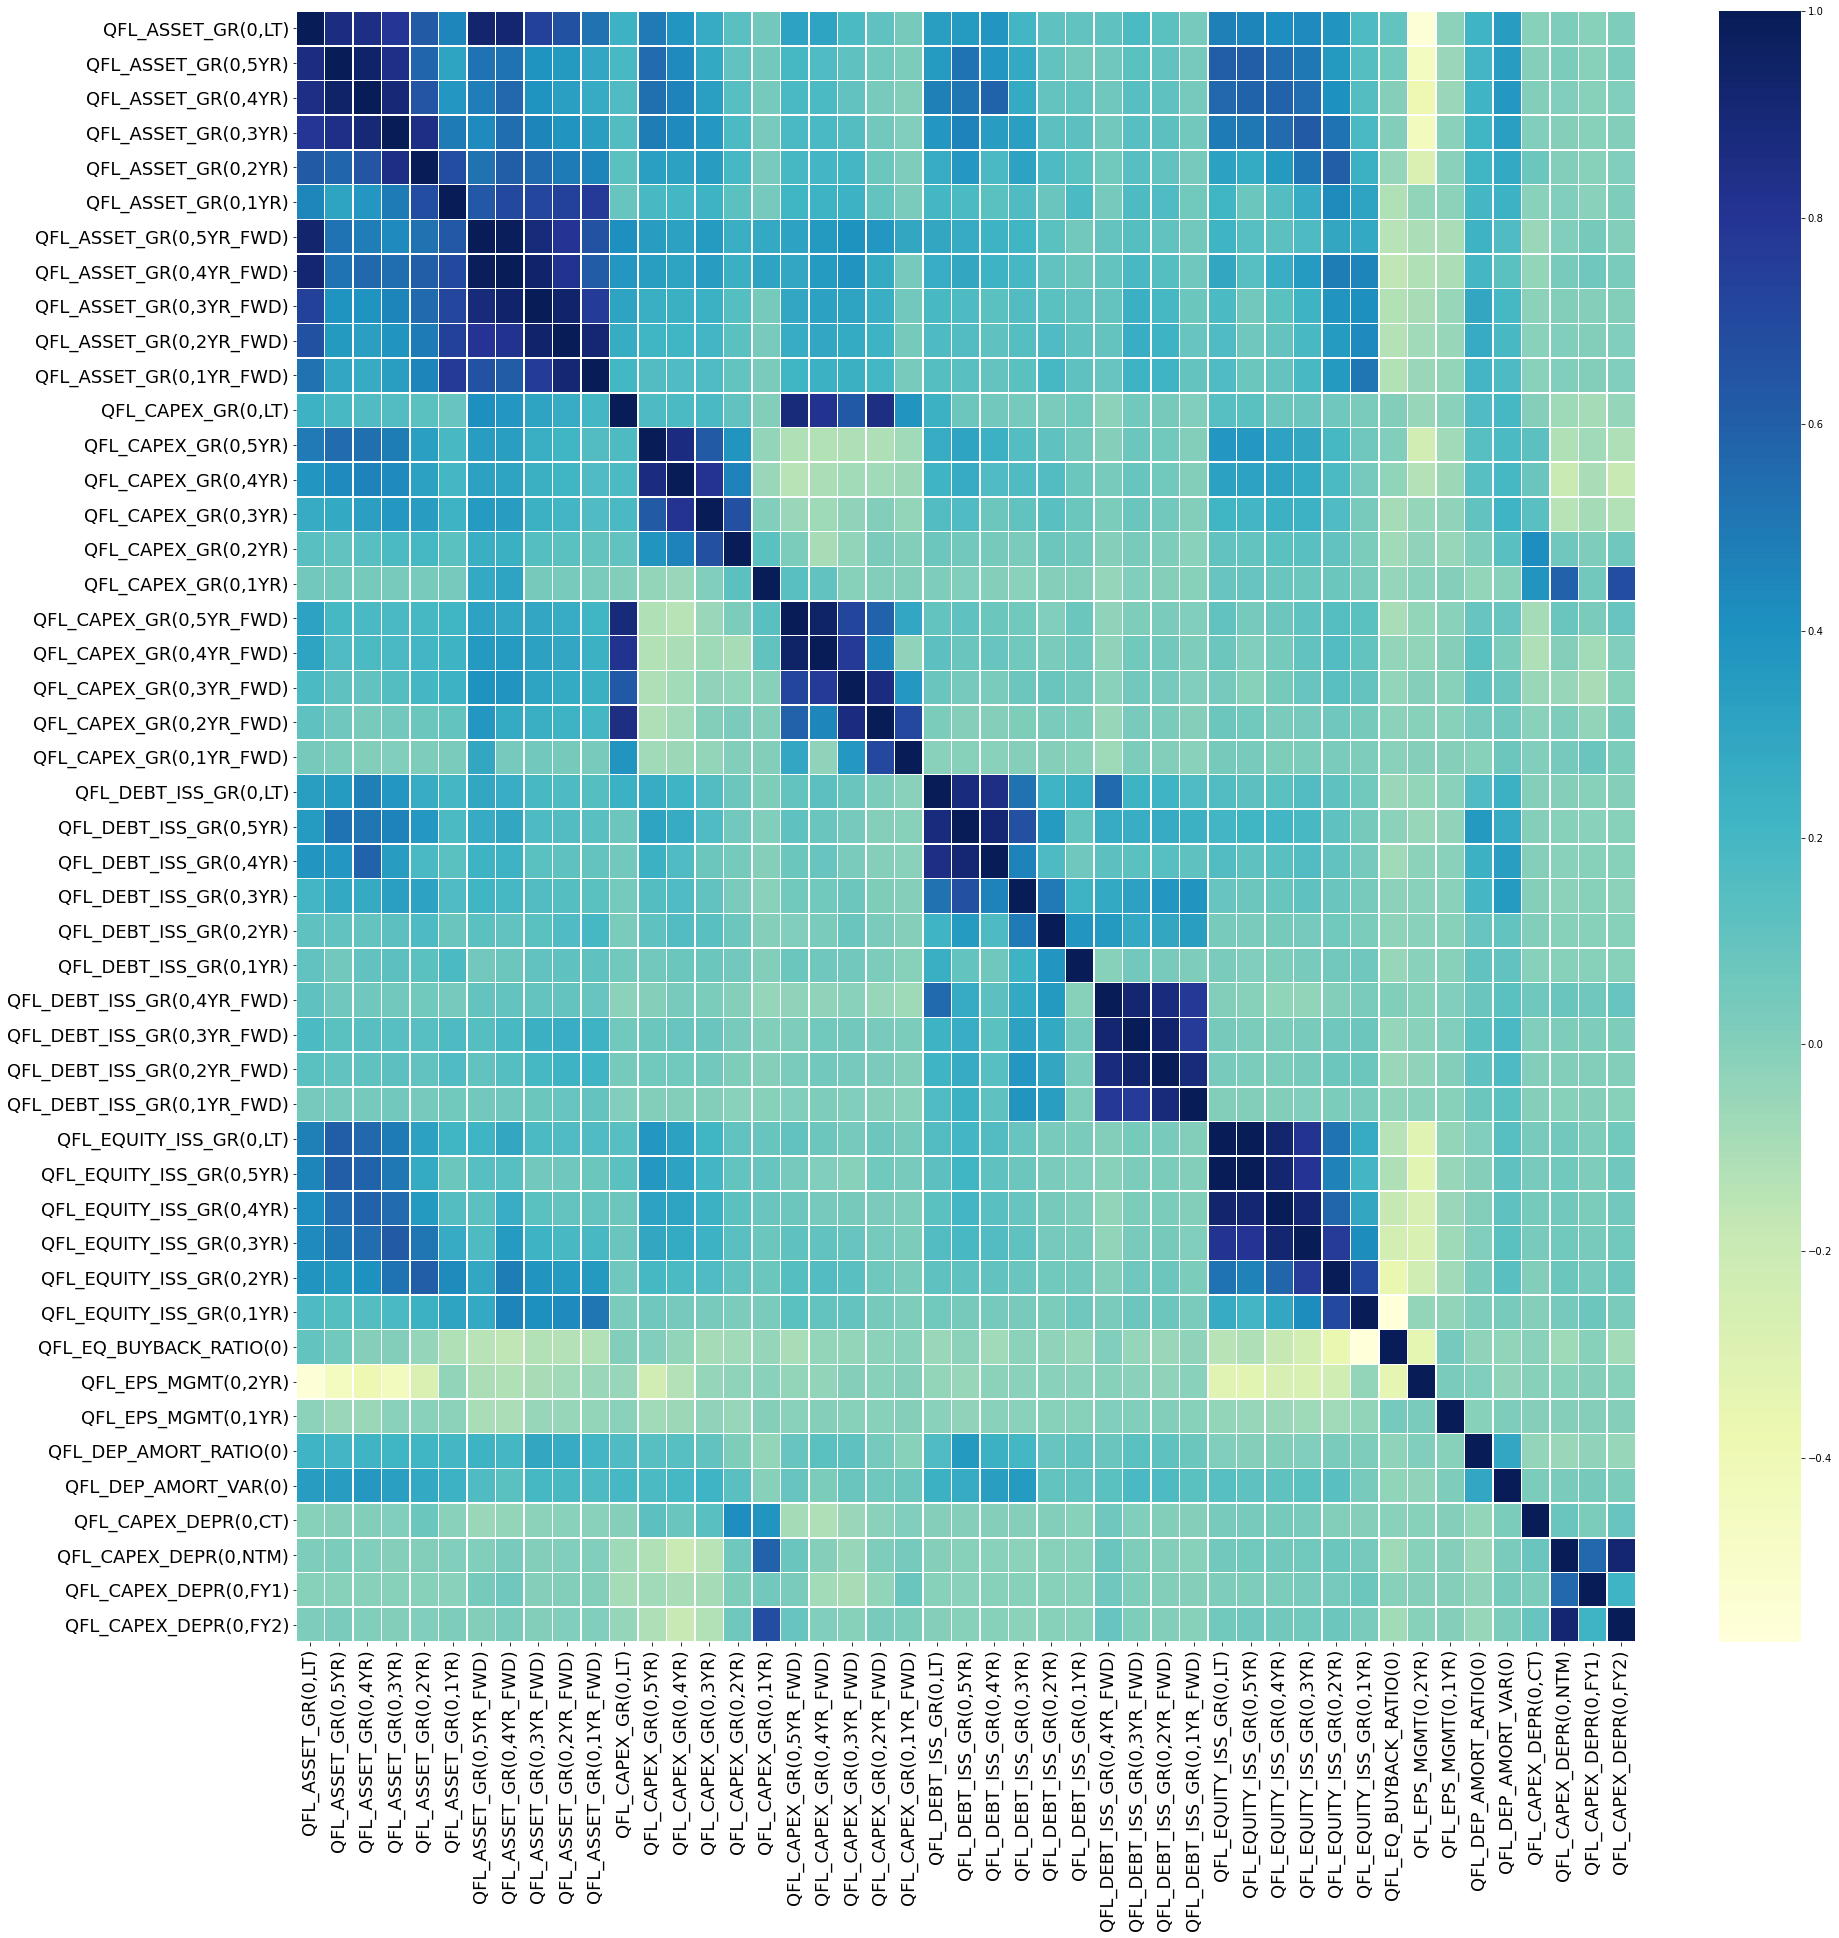

In [66]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

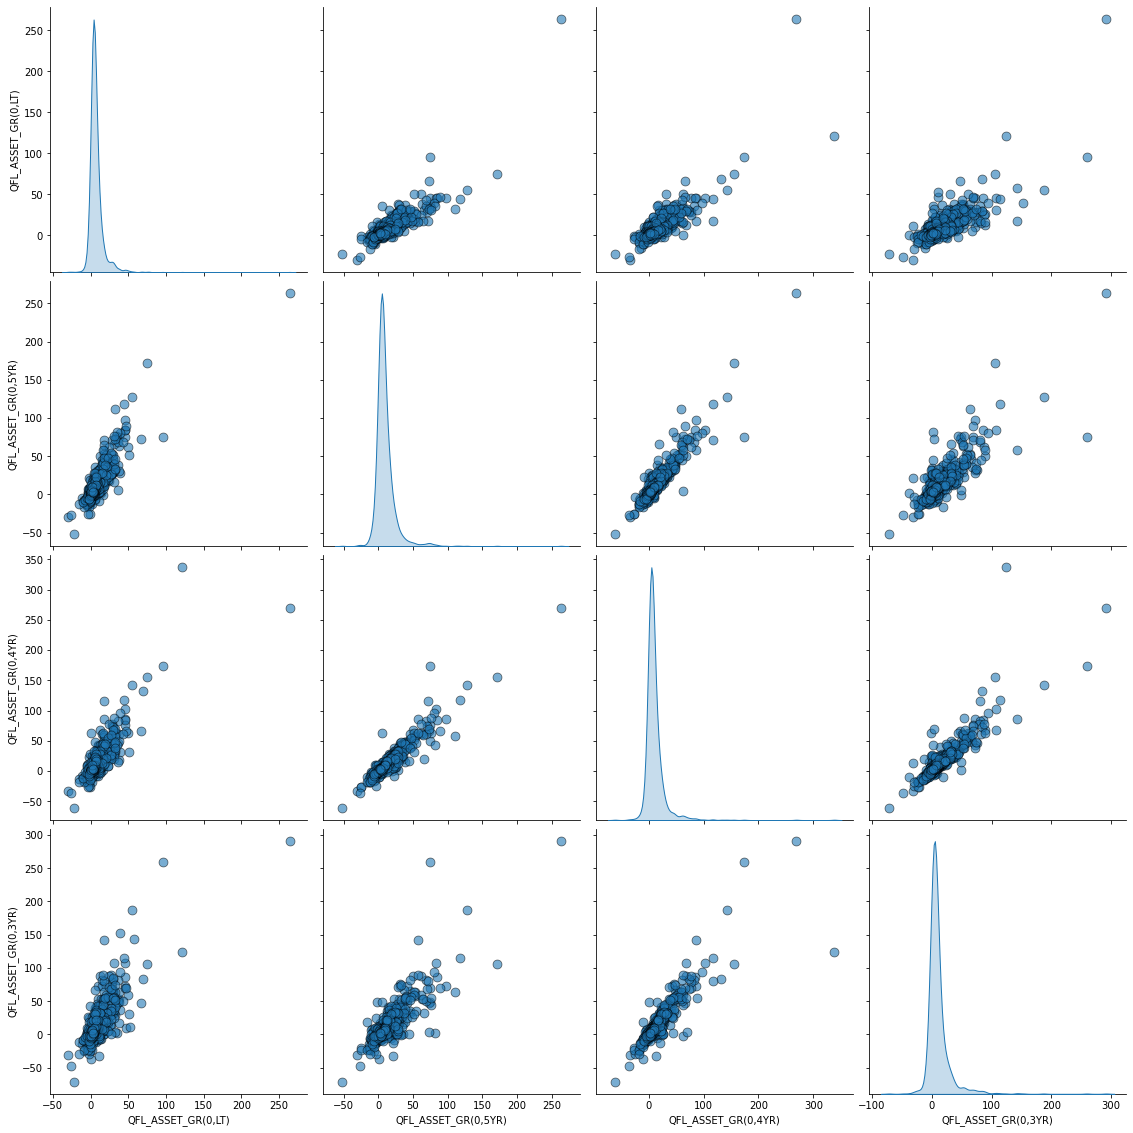

In [67]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [68]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)"
0,14.232402,1.695430,-1.707381,-6.487602
1,10.506919,11.064434,8.155799,7.002950
2,25.321291,38.589787,39.131737,34.145237
3,19.940973,26.453436,25.269270,24.391794
4,14.715008,16.627419,17.029238,16.161573
...,...,...,...,...
1595,3.317663,3.945732,3.606510,2.025211
1596,2.390451,6.243837,5.537581,4.987538
1597,0.316402,4.267192,1.699686,-1.894361
1598,1.678452,9.568810,9.855270,6.511712


In [69]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_ASSET_GR(0,LT)",1596,"[-30.15, 263.73]",7.28,129.51,9.27,172.8
"QFL_ASSET_GR(0,5YR)",1542,"[-51.84, 263.73]",9.67,242.77,5.49,61.21
"QFL_ASSET_GR(0,4YR)",1561,"[-61.16, 338.07]",10.27,360.86,6.98,88.65
"QFL_ASSET_GR(0,3YR)",1582,"[-71.24, 291.55]",10.17,403.42,5.18,49.57
"QFL_ASSET_GR(0,2YR)",1592,"[-70.91, 536.95]",11.58,664.93,7.96,122.1
"QFL_ASSET_GR(0,1YR)",1594,"[-76.94, 533.03]",11.7,1034.79,7.89,95.83
"QFL_ASSET_GR(0,5YR_FWD)",565,"[-13.24, 69.54]",5.43,49.23,3.75,24.72
"QFL_ASSET_GR(0,4YR_FWD)",791,"[-14.34, 104.87]",5.5,66.52,4.85,42.07
"QFL_ASSET_GR(0,3YR_FWD)",1439,"[-18.66, 98.19]",5.71,66.47,3.82,27.34
"QFL_ASSET_GR(0,2YR_FWD)",1483,"[-27.96, 120.52]",6.94,126.19,4.32,29.76


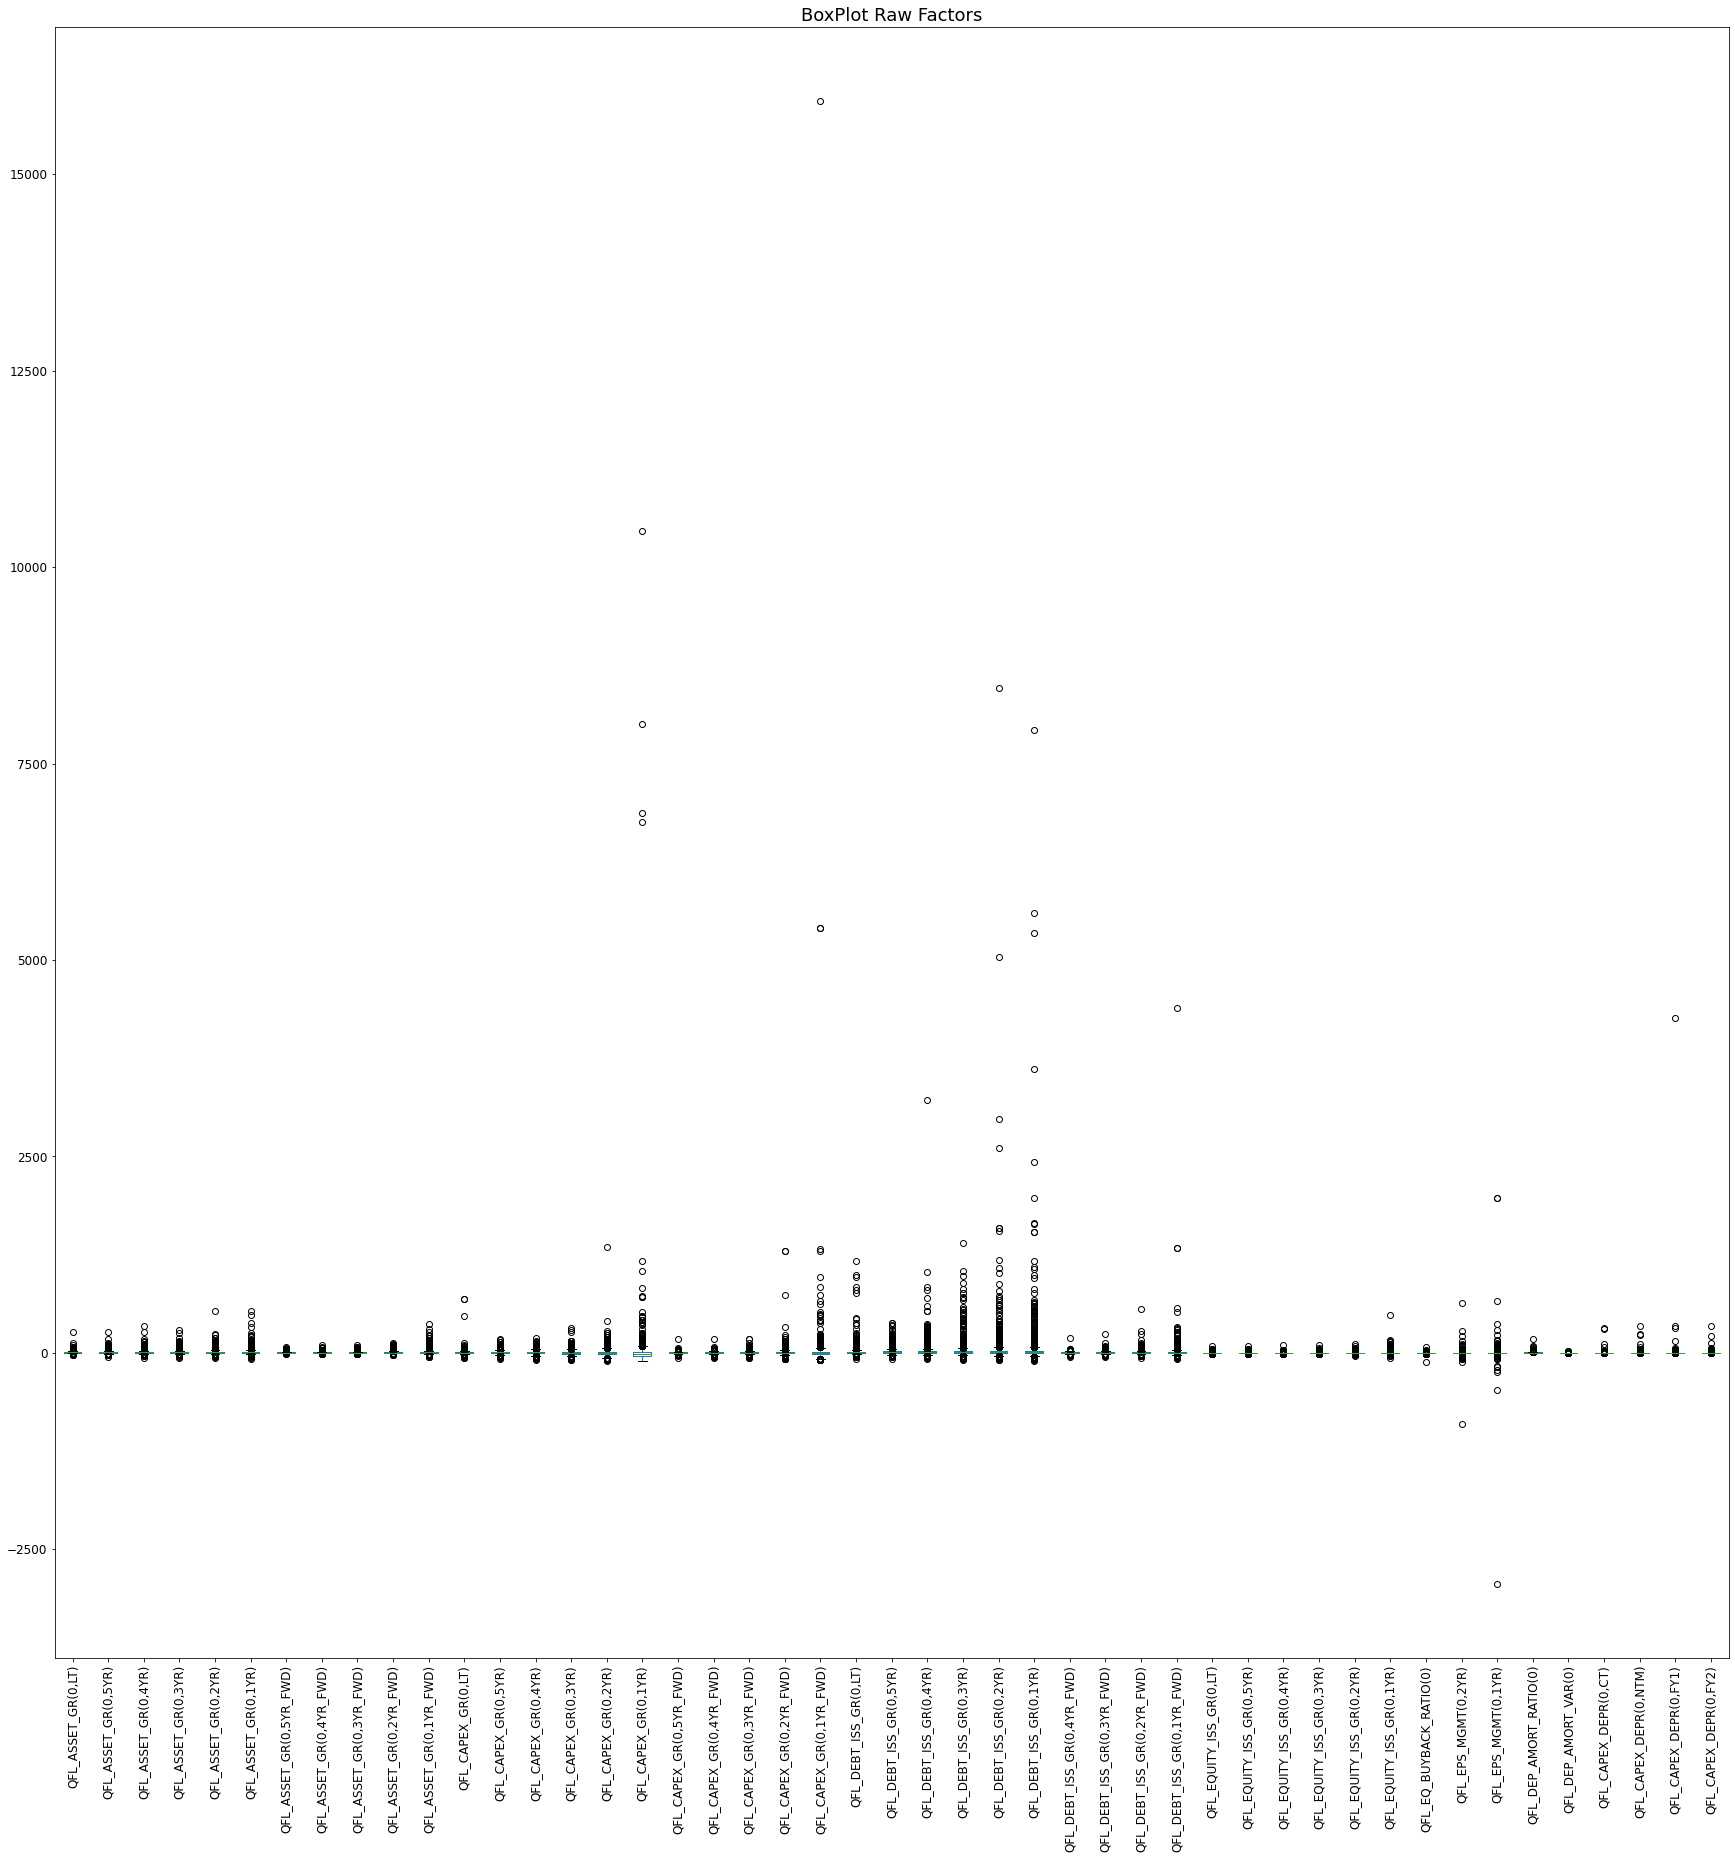

In [70]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [71]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)"
count,1.596000e+03,1.542000e+03,1.561000e+03,1.582000e+03,1.592000e+03,1.594000e+03,5.650000e+02,7.910000e+02,1.439000e+03,1.483000e+03,1.485000e+03,1.562000e+03,1.498000e+03,1.522000e+03,1.544000e+03,1.553000e+03,1.551000e+03,6.640000e+02,8.840000e+02,1.328000e+03,1.349000e+03,1.348000e+03,1.580000e+03,1.480000e+03,1.513000e+03,1.529000e+03,1.534000e+03,1.575000e+03,4.060000e+02,9.250000e+02,1.018000e+03,1.021000e+03,1.592000e+03,1.521000e+03,1.537000e+03,1.552000e+03,1.567000e+03,1.592000e+03,1.594000e+03,1.402000e+03,1.406000e+03,1.073000e+03,1.032000e+03,1.582000e+03,1.349000e+03,1.349000e+03,1.346000e+03
mean,9.337421e-16,1.089343e-16,-8.008399e-17,8.663529e-17,-5.296573e-17,-3.228283e-17,3.840586e-16,-1.116960e-15,2.390760e-16,3.209952e-16,-4.084649e-16,-4.741193e-16,1.111705e-17,6.867773e-17,-4.001549e-16,-1.352749e-16,4.663509e-17,1.025786e-16,2.434892e-17,-2.128276e-16,-1.568324e-17,1.420208e-17,-1.791816e-18,-3.858775e-16,4.292667e-18,-1.802569e-16,-2.855893e-16,-2.098410e-16,-2.823412e-17,-8.215650e-17,-1.425950e-16,-5.945293e-17,6.956328e-17,-7.007325e-17,1.329812e-16,1.994038e-17,9.297321e-17,-1.056351e-16,-1.515500e-16,-2.207132e-17,1.591109e-17,4.142901e-16,-7.685497e-16,-1.543049e-16,-1.373582e-16,-3.834138e-17,-8.041075e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.288199e+00,-3.947720e+00,-3.760479e+00,-4.053287e+00,-3.199184e+00,-2.755434e+00,-2.661523e+00,-2.433464e+00,-2.988821e+00,-3.106325e+00,-2.421069e+00,-2.186091e+00,-4.161518e+00,-4.437446e+00,-3.564156e+00,-2.061441e+00,-2.855506e-01,-5.319335e+00,-4.833352e+00,-3.771084e+00,-1.427510e+00,-2.566548e-01,-1.339658e+00,-2.475397e+00,-1.028537e+00,-1.317006e+00,-4.868030e-01,-4.615536e-01,-4.052307e+00,-3.995798e+00,-2.425928e+00,-6.450222e-01,-2.321309e+00,-2.381430e+00,-2.602630e+00,-3.319504e+00,-4.923741e+00,-3.648182e+00,-2.391684e+01,-2.748719e+01,-2.617851e+01,-7.796139e-01,-5.405603e-01,-1.669783e-01,-1.656666e-01,-7.880174e-02,-1.641508e-01
25%,-4.027555e-01,-4.389380e-01,-4.023885e-01,-4.167633e-01,-3.864617e-01,-3.514883e-01,-4.894970e-01,-4.409500e-01,-4.671485e-01,-4.350555e-01,-3.548627e-01,-2.199197e-01,-5.132038e-01,-5.567315e-01,-5.183838e-01,-4.068982e-01,-1.297169e-01,-3.740827e-01,-3.699115e-01,-3.548345e-01,-2.079453e-01,-1.00342

In [72]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)"
0,22.534955,16.305722,17.255600,14.009523,20.374142,16.206576,9.135387,12.182762,11.343571,10.111033,15.052764,22.792257,8.487153,8.780445,11.175701,26.718769,24.740891,14.697691,13.355458,10.189171,21.547572,32.555337,17.512759,10.246110,30.558191,14.867301,28.798060,24.013678,14.146716,16.378673,20.468357,28.126372,14.506935,15.018469,18.872436,15.813784,15.130947,29.229034,15.935569,19.352415,17.485571,22.655512,12.665878,27.219262,25.046372,36.451782,28.610153
1,10.025057,10.386764,13.621370,12.389144,8.920358,14.784971,8.438701,8.280219,8.767307,9.276470,12.002388,22.792257,7.916372,6.530814,10.006734,8.121652,18.938919,5.457938,5.762696,10.065069,21.547572,11.006256,14.884051,10.100926,9.586841,11.019516,17.059907,16.936630,3.506403,8.251993,10.177032,8.446875,9.520202,9.862336,7.001666,10.595085,12.781207,9.657796,6.874003,8.503643,17.485571,11.074257,11.750827,25.916736,17.329506,2.848708,17.570517
2,7.739204,7.586620,8.602901,8.792709,8.531871,11.401168,6.499533,7.160850,8.746690,8.738286,10.738411,15.601600,6.916633,6.004789,9.351818,5.543483,16.227582,3.623803,5.059288,7.042111,12.299575,11.006256,14.367198,9.480650,7.802947,10.328227,9.998223,16.158867,3.110024,6.129044,8.854644,8.438291,8.950210,9.272982,6.990246,7.134556,8.787966,9.023945,3.733696,6.604120,5.853179,8.951136,10.092546,9.343220,16.116713,2.682596,10.037336
3,6.200984,6.930050,7.610502,7.114505,7.100304,10.011692,3.905591,7.140863,8.211338,8.174311,9.176076,3.945122,6.876475,5.877944,5.345755,5.073541,15.973835,3.527936,3.534175,5.937802,5.355653,2.636186,12.522954,8.968696,7.366443,9.328412,8.757077,10.864027,3.017324,5.364460,5.857354,3.525824,7.005987,6.909465,6.394736,6.328067,7.764737,8.557982,3.694759,4.612751,3.243394,7.164139,10.007290,6.443304,8.462921,1.230938,5.290916
4,5.973092,6.525641,6.961334,6.622590,6.757275,7.478632,3.795377,6.586317,6.563058,7.591827,8.610634,3.287574,6.751625,5.087133,5.285896,4.953253,2.733357,3.175020,3.504102,5.326834,3.716499,2.587228,11.829877,8.066535,6.480909,8.479814,5.278386,7.254100,2.366686,4.877293,4.490602,3.241498,6.664344,6.020767,6.344280,6.146769,7.423850,7.902812,3.515432,3.414267,2.524302,5.263375,7.468032,3.320045,5.403000,0.471693,4.144663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-3.288199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [73]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)"
0,-3.288199,-3.947720,-3.760479,-4.053287,-3.199184,-2.755434,-2.661523,-2.433464,-2.988821,-3.106325,-2.421069,-2.186091,-4.161518,-4.437446,-3.564156,-2.061441,-0.285551,-5.319335,-4.833352,-3.771084,-1.427510,-0.256655,-1.339658,-2.475397,-1.028537,-1.317006,-0.486803,-0.461554,-4.052307,-3.995798,-2.425928,-0.645022,-2.321309,-2.381430,-2.602630,-3.319504,-4.923741,-3.648182,-23.916844,-27.487192,-26.178506,-0.779614,-0.540560,-0.166978,-0.165667,-0.078802,-0.164151
1,-2.953447,-2.555373,-2.474620,-2.866892,-2.358805,-2.517706,-1.971026,-2.182497,-2.916268,-3.046737,-2.409346,-2.177564,-3.711904,-4.312585,-3.291138,-1.950907,-0.285120,-3.261155,-4.728565,-3.722141,-1.412100,-0.256088,-1.121002,-2.075124,-0.884805,-1.172053,-0.476746,-0.452741,-2.601653,-3.181124,-1.863111,-0.577545,-2.155333,-2.209816,-2.410159,-2.804416,-3.066167,-2.840148,-4.379654,-3.546937,-4.243783,-0.779494,-0.539835,-0.144874,-0.156510,-0.078317,-0.163976
2,-2.600794,-2.310872,-2.313285,-2.375165,-2.214273,-2.161785,-1.691498,-1.981069,-2.799413,-2.806613,-2.390028,-2.057263,-3.533074,-4.096295,-3.051973,-1.851182,-0.283935,-2.988892,-4.200286,-3.672773,-1.395652,-0.254782,-1.067471,-2.060100,-0.863541,-1.168190,-0.450801,-0.417787,-2.502542,-3.076001,-1.745933,-0.554372,-2.089689,-2.117762,-2.410159,-2.709491,-3.011244,-2.711581,-3.908834,-2.441212,-2.203819,-0.777929,-0.535570,-0.144874,-0.156360,-0.047187,-0.160066
3,-2.041803,-2.252259,-1.953302,-2.084446,-2.189656,-1.625900,-1.684053,-1.981069,-2.736240,-2.240449,-2.137170,-1.950537,-3.062317,-3.481119,-3.004481,-1.821682,-0.280338,-2.823967,-4.185674,-3.630787,-1.393319,-0.254588,-0.963161,-1.977129,-0.833566,-1.065157,-0.449968,-0.409147,-2.332620,-2.665098,-1.684849,-0.534375,-2.066303,-1.941957,-2.322861,-2.709491,-2.996783,-1.601354,-3.855209,-2.261826,-1.952275,-0.777170,-0.533240,-0.144874,-0.152876,-0.046881,-0.159729
4,-2.033504,-2.250179,-1.946188,-2.042965,-2.062065,-1.609182,-1.419182,-1.887941,-2.324503,-2.219082,-1.793695,-1.842809,-2.776142,-3.329461,-2.890405,-1.788337,-0.276963,-2.378111,-3.536616,-3.581695,-1.378920,-0.253939,-0.921558,-1.710022,-0.729534,-0.989305,-0.386639,-0.403605,-2.208779,-2.312069,-1.683515,-0.519094,-2.049986,-1.941957,-2.285536,-2.445263,-2.715075,-1.179368,-3.804108,-1.943473,-1.565309,-0.776665,-0.531022,-0.144874,-0.152595,-0.045383,-0.158443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,22.534955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

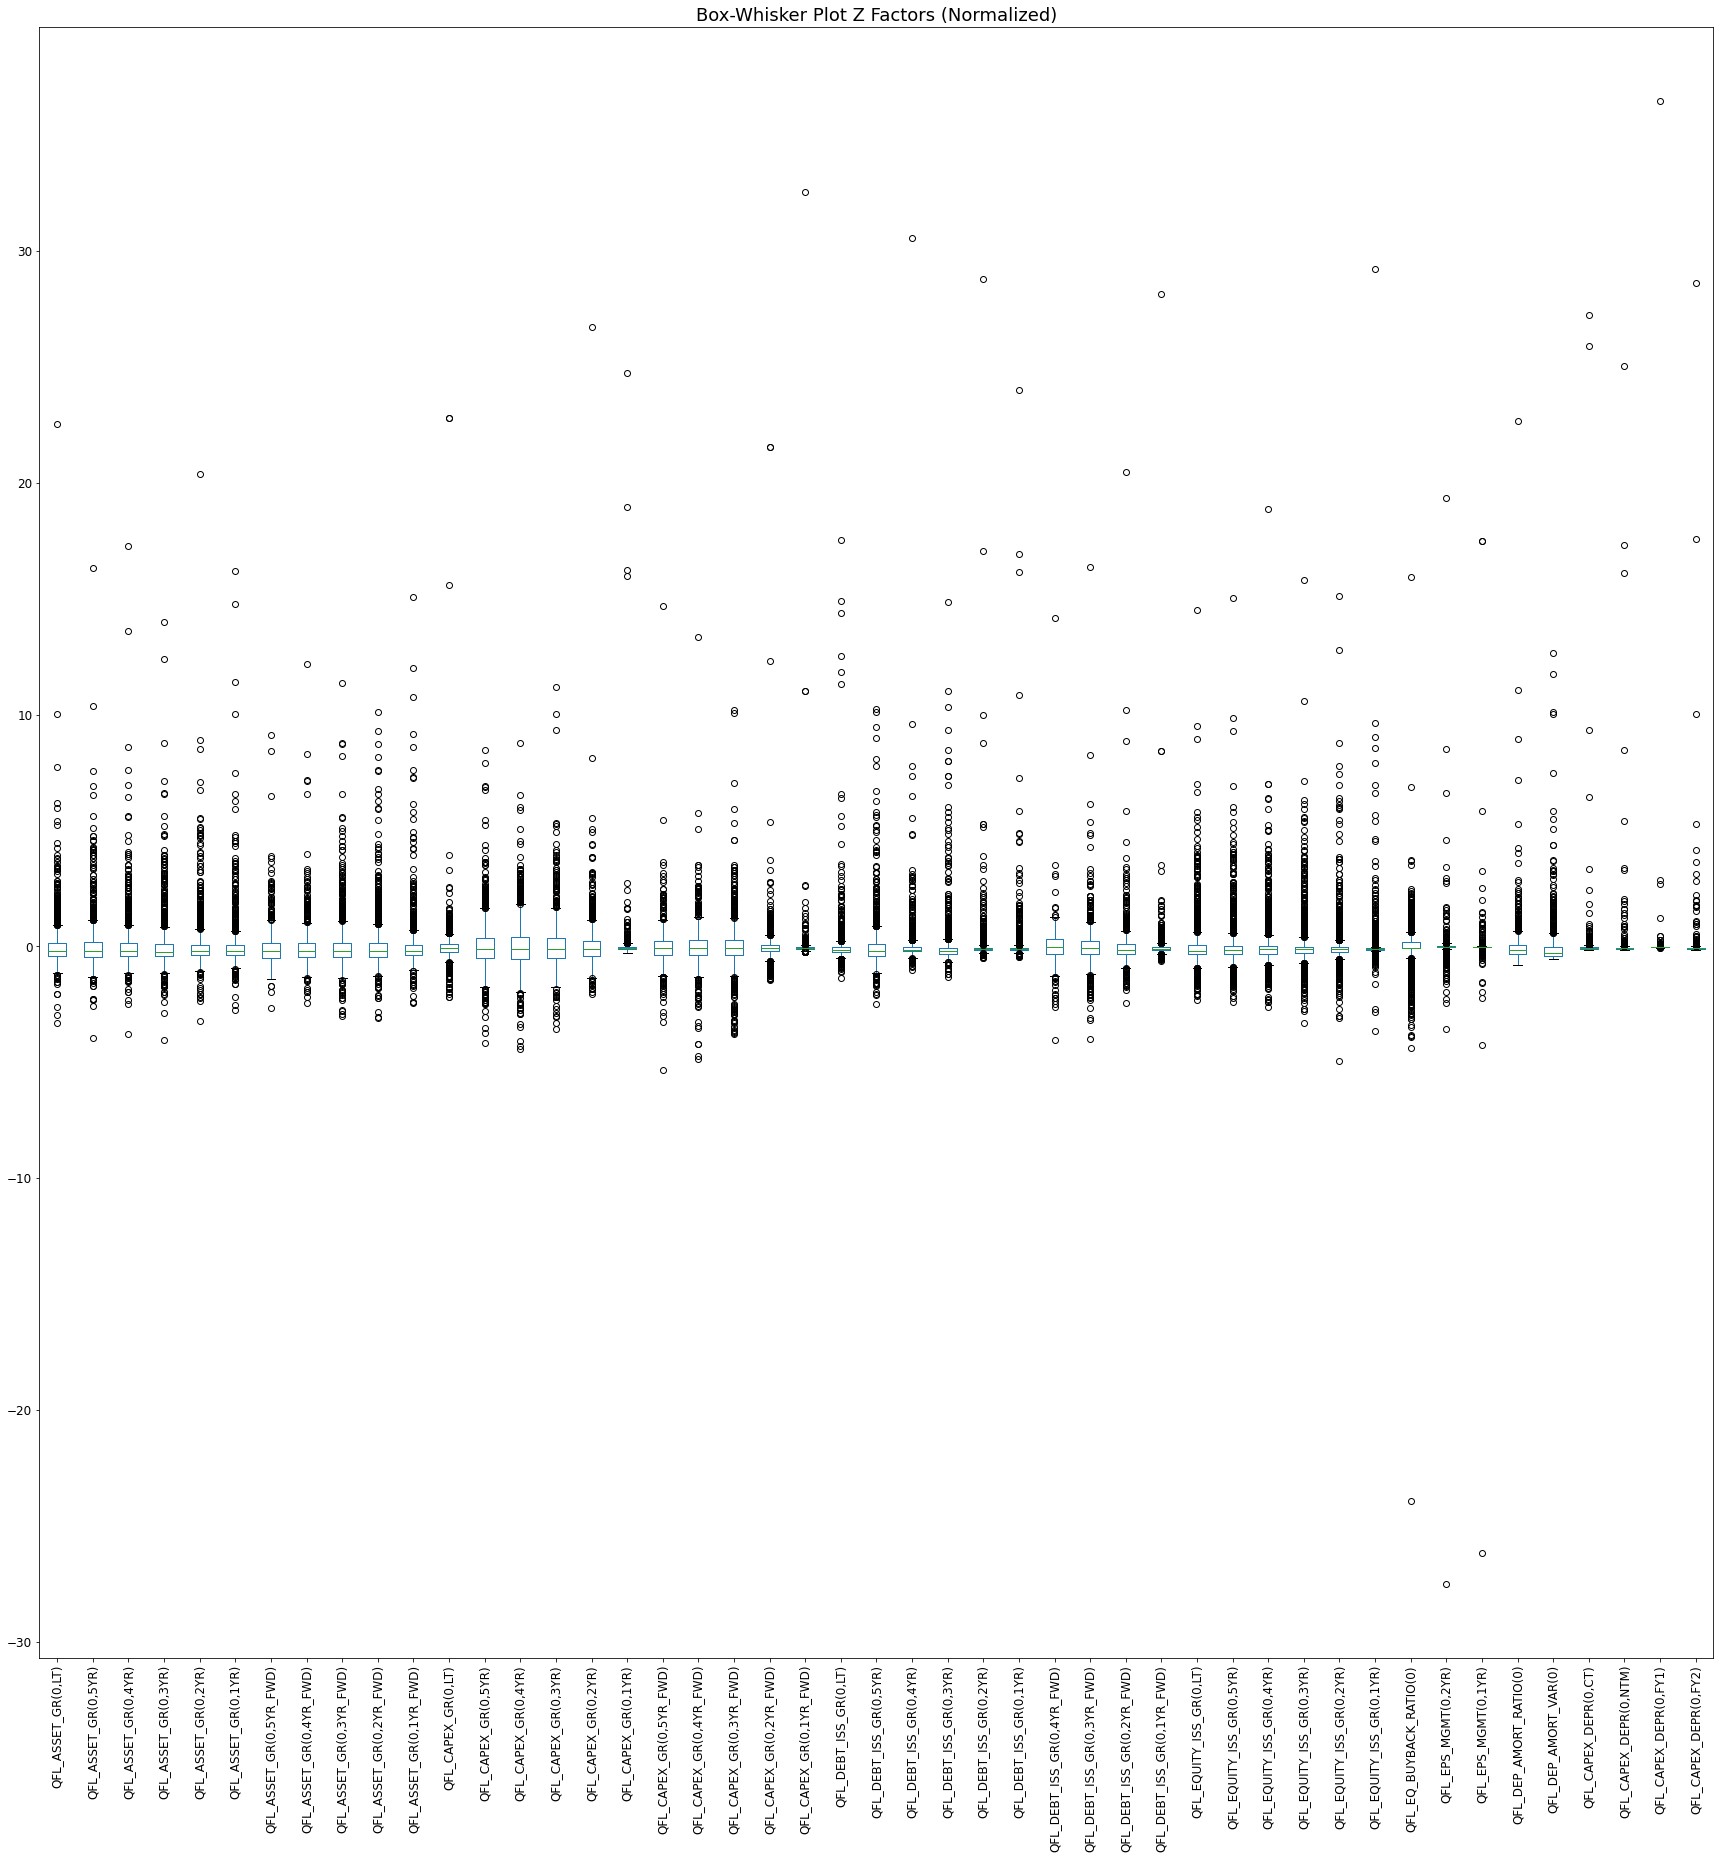

In [74]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [75]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)",MFR
0,-3.288199,-3.947720,-3.760479,-4.053287,-3.199184,-2.755434,-2.661523,-2.433464,-2.988821,-3.106325,-2.421069,-2.186091,-4.161518,-4.437446,-3.564156,-2.061441,-0.285551,-5.319335,-4.833352,-3.771084,-1.427510,-0.256655,-1.339658,-2.475397,-1.028537,-1.317006,-0.486803,-0.461554,-4.052307,-3.995798,-2.425928,-0.645022,-2.321309,-2.381430,-2.602630,-3.319504,-4.923741,-3.648182,-23.916844,-27.487192,-26.178506,-0.779614,-0.540560,-0.166978,-0.165667,-0.078802,-0.164151,-3.911123
1,-2.953447,-2.555373,-2.474620,-2.866892,-2.358805,-2.517706,-1.971026,-2.182497,-2.916268,-3.046737,-2.409346,-2.177564,-3.711904,-4.312585,-3.291138,-1.950907,-0.285120,-3.261155,-4.728565,-3.722141,-1.412100,-0.256088,-1.121002,-2.075124,-0.884805,-1.172053,-0.476746,-0.452741,-2.601653,-3.181124,-1.863111,-0.577545,-2.155333,-2.209816,-2.410159,-2.804416,-3.066167,-2.840148,-4.379654,-3.546937,-4.243783,-0.779494,-0.539835,-0.144874,-0.156510,-0.078317,-0.163976,-2.155049
2,-2.600794,-2.310872,-2.313285,-2.375165,-2.214273,-2.161785,-1.691498,-1.981069,-2.799413,-2.806613,-2.390028,-2.057263,-3.533074,-4.096295,-3.051973,-1.851182,-0.283935,-2.988892,-4.200286,-3.672773,-1.395652,-0.254782,-1.067471,-2.060100,-0.863541,-1.168190,-0.450801,-0.417787,-2.502542,-3.076001,-1.745933,-0.554372,-2.089689,-2.117762,-2.410159,-2.709491,-3.011244,-2.711581,-3.908834,-2.441212,-2.203819,-0.777929,-0.535570,-0.144874,-0.156360,-0.047187,-0.160066,-1.965179
3,-2.041803,-2.252259,-1.953302,-2.084446,-2.189656,-1.625900,-1.684053,-1.981069,-2.736240,-2.240449,-2.137170,-1.950537,-3.062317,-3.481119,-3.004481,-1.821682,-0.280338,-2.823967,-4.185674,-3.630787,-1.393319,-0.254588,-0.963161,-1.977129,-0.833566,-1.065157,-0.449968,-0.409147,-2.332620,-2.665098,-1.684849,-0.534375,-2.066303,-1.941957,-2.322861,-2.709491,-2.996783,-1.601354,-3.855209,-2.261826,-1.952275,-0.777170,-0.533240,-0.144874,-0.152876,-0.046881,-0.159729,-1.813895
4,-2.033504,-2.250179,-1.946188,-2.042965,-2.062065,-1.609182,-1.419182,-1.887941,-2.324503,-2.219082,-1.793695,-1.842809,-2.776142,-3.329461,-2.890405,-1.788337,-0.276963,-2.378111,-3.536616,-3.581695,-1.378920,-0.253939,-0.921558,-1.710022,-0.729534,-0.989305,-0.386639,-0.403605,-2.208779,-2.312069,-1.683515,-0.519094,-2.049986,-1.941957,-2.285536,-2.445263,-2.715075,-1.179368,-3.804108,-1.943473,-1.565309,-0.776665,-0.531022,-0.144874,-0.152595,-0.045383,-0.158443,-1.685640


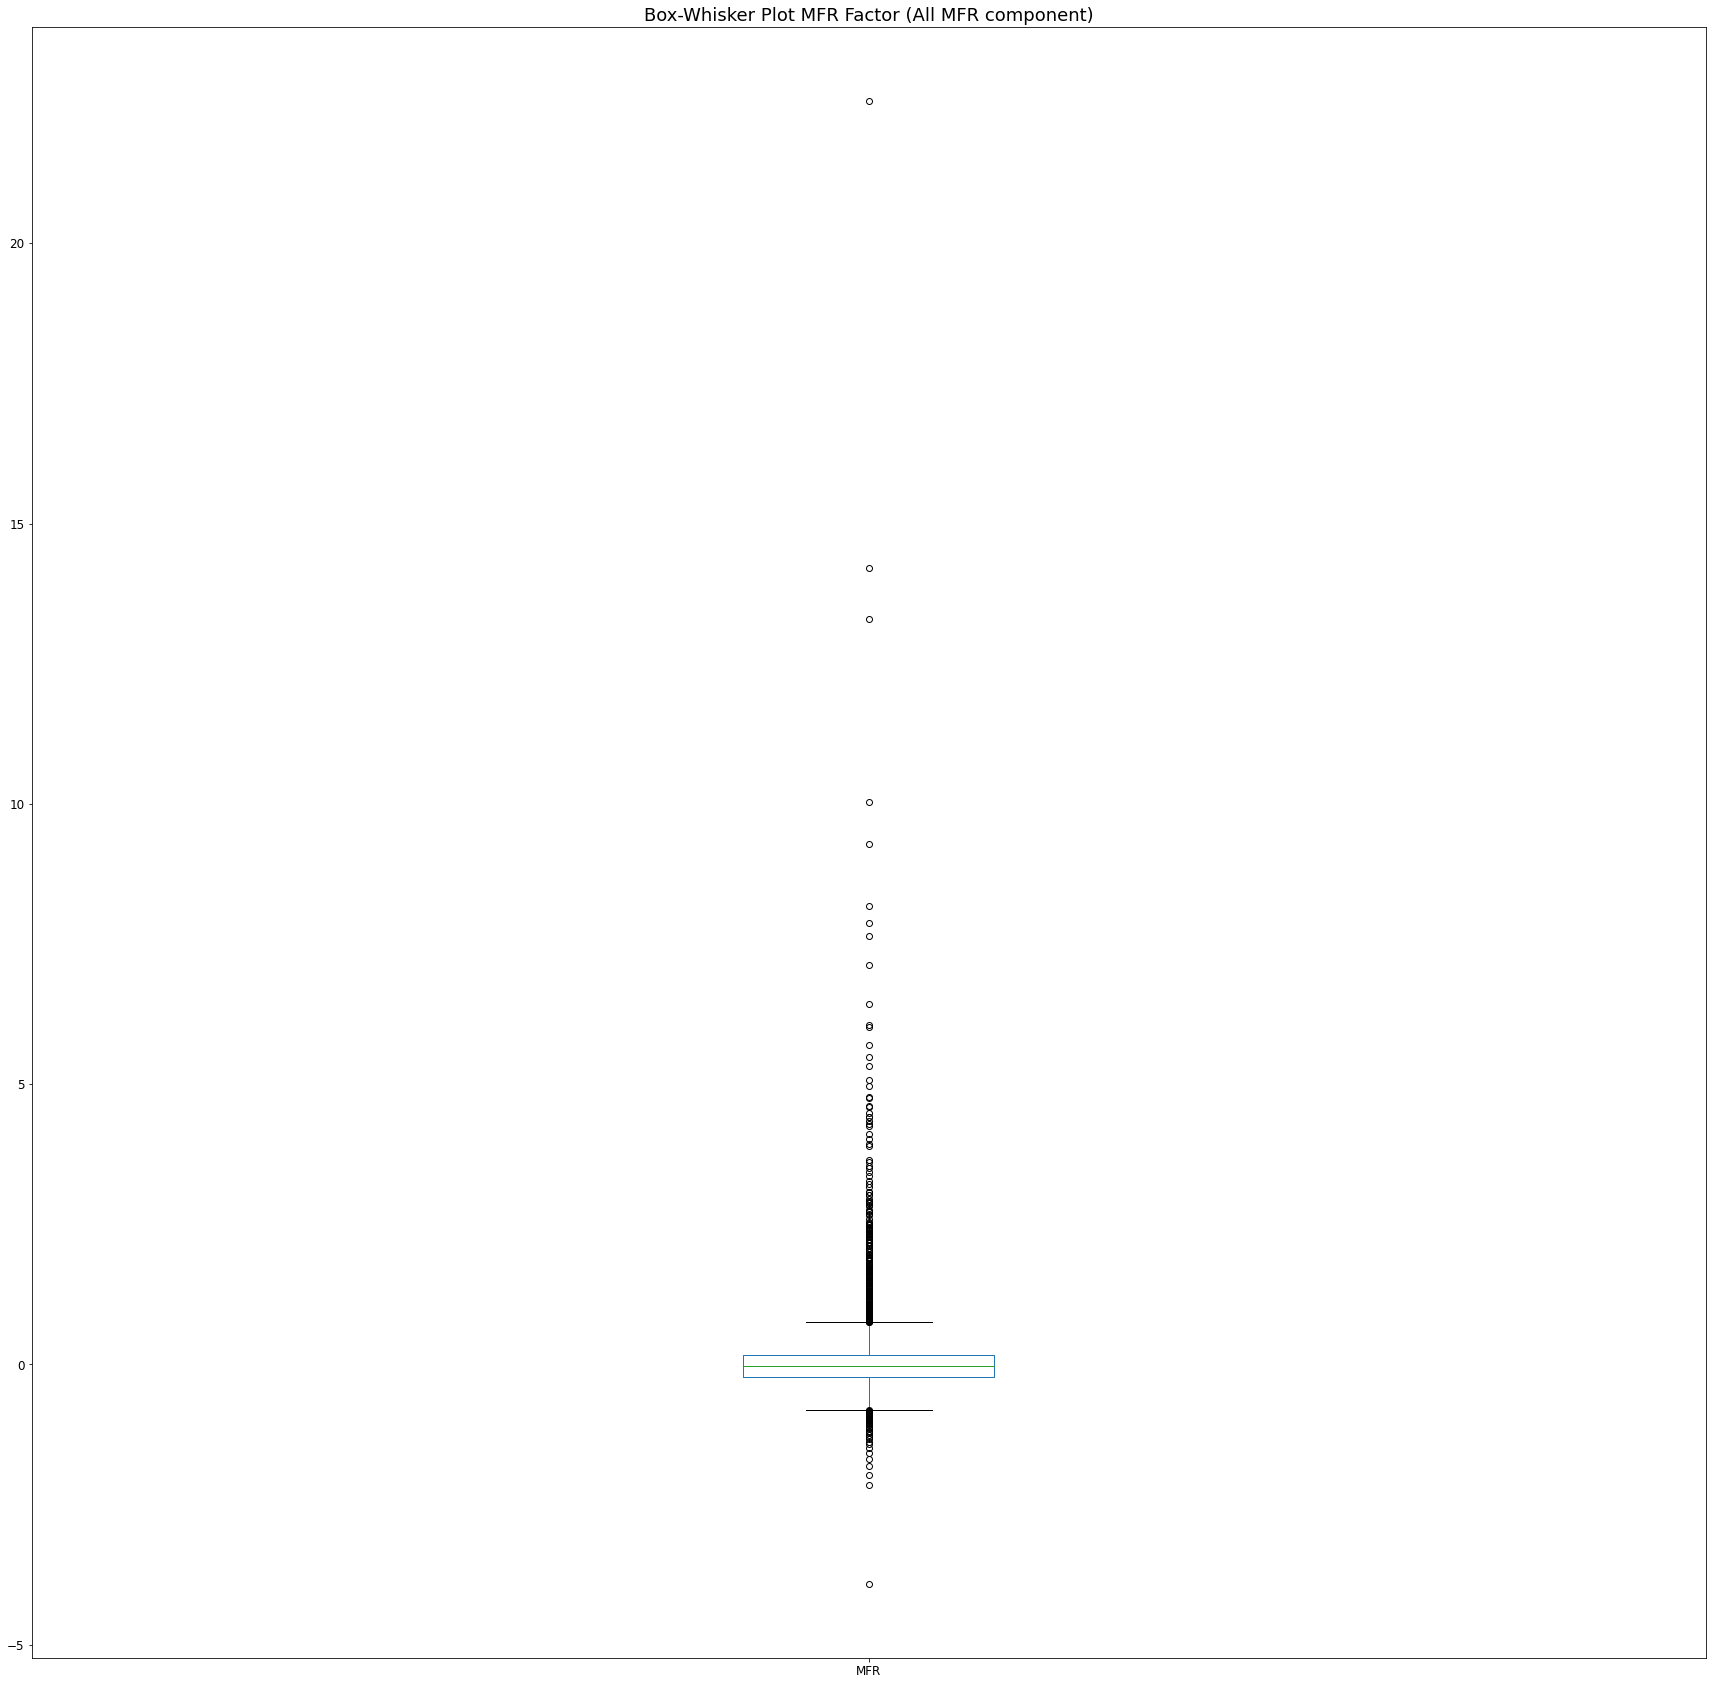

In [76]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

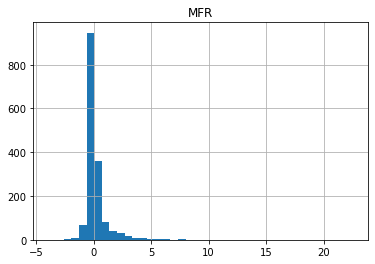

In [77]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [78]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


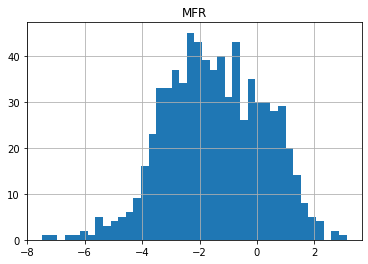

In [79]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [80]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)"
0,14.232402,1.695430,-1.707381,-6.487602,-6.769890,-6.166559,18.641983,16.383162,8.334882,0.674282,0.323057,-3.274627,-12.585688,-17.143047,-25.134813,-27.651560,-37.684650,0.067768,2.301311,9.811879,24.030650,50.918533,4.721322,11.385763,5.804861,0.231421,4.306352,12.432742,NaN,NaN,0.000000,0.000000,-5.634582,-5.634582,-5.999499,-6.356990,-5.954141,-4.802382,5.306195,6.811154,6.040931,NaN,NaN,0.661089,0.901729,0.902168,0.899589
1,10.506919,11.064434,8.155799,7.002950,8.520770,9.004652,NaN,NaN,10.148942,9.147401,8.306876,15.733818,21.386242,24.667858,20.944489,19.020473,51.222800,NaN,NaN,12.200121,16.039371,22.062477,5.252995,12.079012,-0.082612,-2.046847,-2.550513,-4.867434,NaN,0.106457,0.177492,0.355299,-0.819236,-0.819236,-0.591624,-0.664943,-0.862533,-0.942332,1.770622,1.236820,1.065230,8.056472,-0.294293,1.360305,1.593058,1.622348,1.557732
2,25.321291,38.589787,39.131737,34.145237,36.652040,39.623760,21.917560,22.079683,22.007670,25.596766,33.420467,20.962788,45.255684,43.213417,41.731430,78.630830,127.306010,14.852304,21.782967,27.358932,42.731700,111.827660,25.551268,47.610428,50.443413,34.597755,39.550900,30.370104,NaN,8.919565,17.703426,40.639690,1.408195,1.408195,1.418483,1.365161,1.279020,1.185274,0.000000,-1.069260,-1.884329,14.437173,0.336564,1.286771,0.974764,1.203026,0.957236
3,19.940973,26.453436,25.269270,24.391794,26.472950,16.051388,18.270350,19.277893,22.169395,22.172838,19.467426,16.395721,44.034256,37.877083,18.353440,-3.090429,-5.590177,9.230174,11.677859,15.541223,17.412542,4.697917,72.560680,72.560680,121.162674,886.410030,667.699800,12.734282,NaN,NaN,NaN,NaN,-0.173599,-0.173599,-0.566298,-0.689107,-0.212008,-0.145960,1.057473,1.092124,-0.020278,7.894865,-0.229018,2.257925,2.459521,2.283508,2.472958
4,14.715008,16.627419,17.029238,16.161573,14.472866,11.279499,14.224422,14.043776,13.843359,13.675201,12.505142,10.066931,27.479362,23.887932,8.055997,-1.461017,-19.888723,5.552595,6.179210,8.136164,6.962104,-3.357609,14.927113,39.615560,66.267300,99.529335,136.853700,79.937980,NaN,-3.686964,-6.069107,-11.769873,-0.118238,-0.118238,-0.407648,-0.863880,-1.479888,-2.011538,3.248194,-0.156784,-1.830721,8.923497,-0.929563,1.707434,1.665318,1.668292,1.665086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3.317663,3.945732,3.606510,2.025211,4.128361,4.488623,NaN,NaN,2.884123,3.391719,6.251077,16.722965,16.722965,3.773975,-23.663473,-79.392426,-83.468540,NaN,NaN,NaN,NaN,NaN,4.637395,3.809726,3.896999,2.775145,8.426559,17.990685,NaN,5.261423,6.024523,11.235206,2.577853,2.577853,3.017116,3.331697,2.157223,0.929046,0.000024,-2.254099,-0.656694,0.026437,-6.367759,0.155303,NaN,NaN,NaN
1596,2.390451,6.243837,5.537581,4.987538,2.006042,7.19

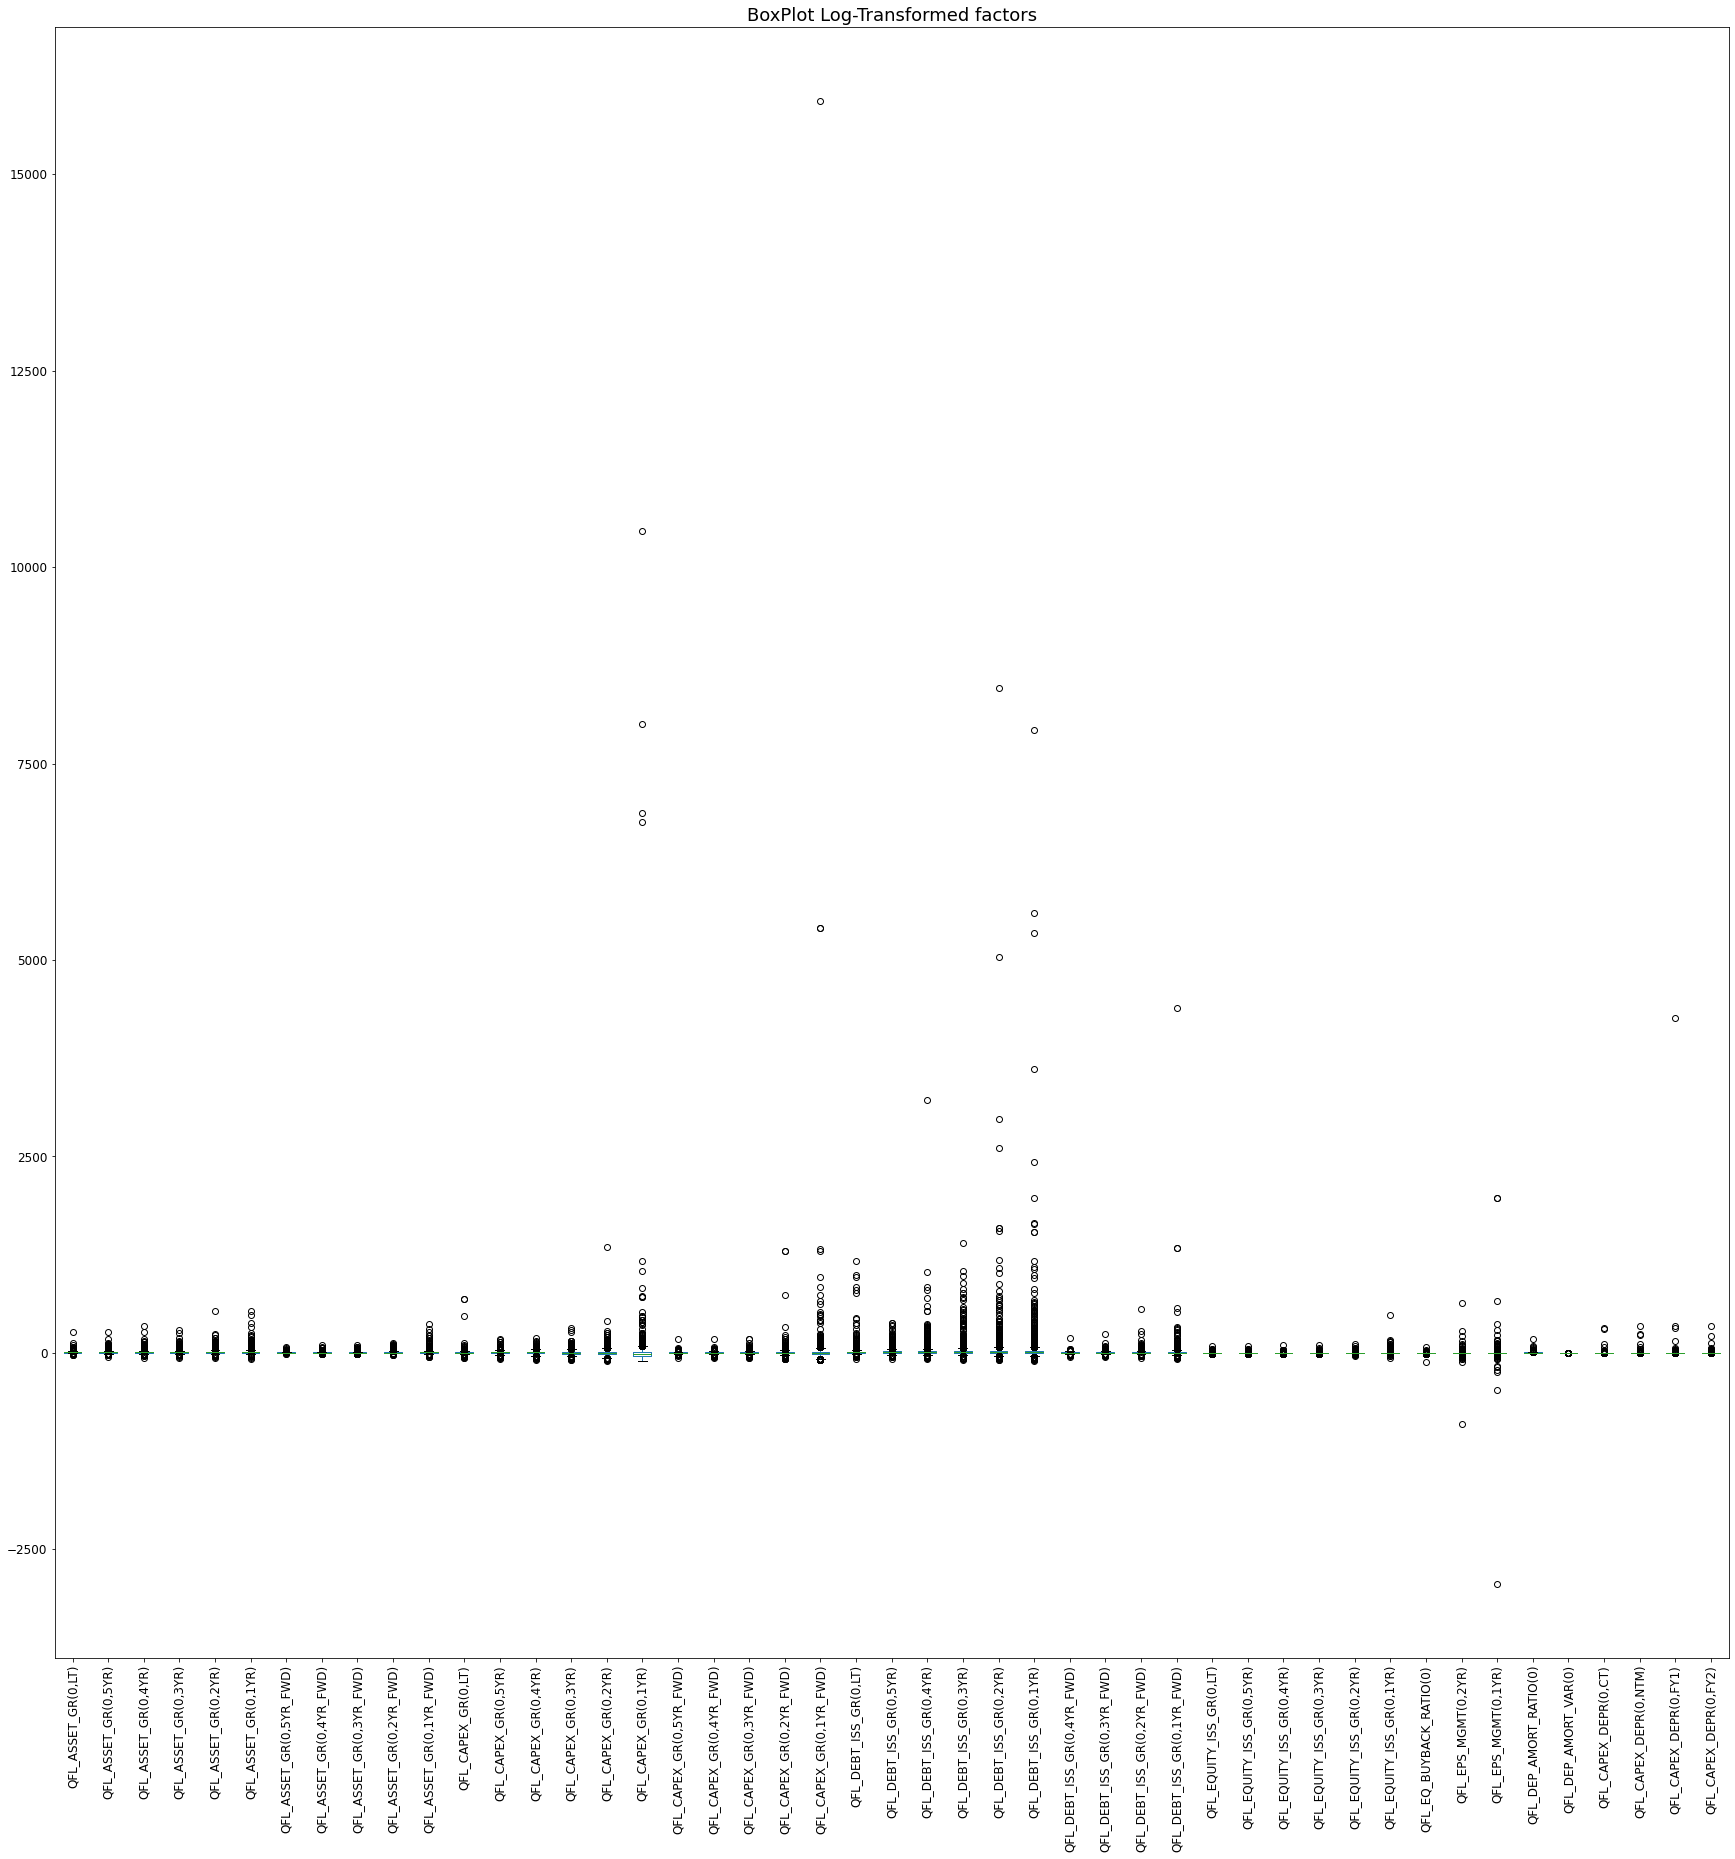

In [81]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [82]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)",MFR
0,0.611346,-0.511801,-0.630666,-0.829245,-0.711614,-0.555353,1.882227,1.333885,0.322454,-0.557389,-0.430959,-0.303449,-1.022009,-1.174591,-1.120966,-0.637867,-0.138895,-0.239457,-0.064881,0.382095,0.288936,0.043153,-0.159762,-0.130149,-0.174344,-0.320997,-0.149464,-0.122240,NaN,NaN,-0.209066,-0.132959,-1.193155,-1.214952,-1.199326,-1.152951,-0.942904,-0.393473,1.037826,0.197057,0.038975,NaN,NaN,-0.088153,-0.090365,-0.036733,-0.089474,-0.246318
1,0.283982,0.089511,-0.111452,-0.157581,-0.118636,-0.083731,NaN,NaN,0.544964,0.196875,-0.100045,0.336811,0.728823,0.800805,0.516520,0.292027,0.071895,NaN,NaN,0.524717,0.155062,-0.015933,-0.151686,-0.110872,-0.230670,-0.345805,-0.172922,-0.175017,NaN,-0.159002,-0.202437,-0.130669,-0.326865,-0.319235,-0.235294,-0.221220,-0.225319,-0.160631,0.295254,0.027337,-0.005323,0.307180,0.428004,-0.028161,-0.039653,-0.030558,-0.034840,0.040624
2,1.585745,1.856116,1.519174,1.193772,0.972306,0.868113,2.349049,2.032307,1.999540,1.661170,0.940864,0.512938,1.958997,1.677008,1.255210,1.479705,0.252280,1.020814,1.446413,1.429979,0.602224,0.167871,0.156656,0.877184,0.252718,0.053211,-0.028890,-0.067518,NaN,0.448609,0.452125,0.129042,0.073854,0.095097,0.123037,0.111087,0.076500,-0.032292,-0.076627,-0.042875,-0.031583,1.167917,0.996907,-0.034470,-0.085007,-0.034153,-0.084689,0.723422
3,1.112968,1.077193,0.789430,0.708170,0.577557,0.135328,1.829264,1.688793,2.019377,1.356378,0.362538,0.359106,1.896047,1.424888,0.424444,-0.148510,-0.062802,0.541569,0.662507,0.724243,0.178066,-0.051489,0.870756,1.570998,0.929298,9.328412,2.120049,-0.121320,NaN,NaN,NaN,NaN,-0.210714,-0.199138,-0.230779,-0.225176,-0.133638,-0.112593,0.145473,0.022932,-0.014988,0.285380,0.486869,0.048855,0.023905,-0.024889,0.041135,0.748974
4,0.653754,0.446549,0.355661,0.298406,0.112189,-0.013014,1.252655,1.047065,0.998116,0.599932,0.073965,0.145934,1.042848,0.763957,0.058511,-0.116046,-0.096703,0.228083,0.235948,0.282024,0.002996,-0.067984,-0.004731,0.654863,0.404107,0.760237,0.303989,0.083699,NaN,-0.420536,-0.435736,-0.208839,-0.200755,-0.188840,-0.202498,-0.253784,-0.312326,-0.225127,0.605587,-0.015093,-0.031106,0.424139,-0.144878,0.001623,-0.034352,-0.030164,-0.025928,0.191487


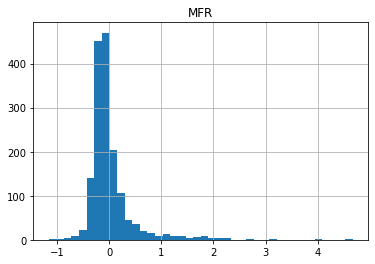

In [83]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [84]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: 0.01
Information Coefficient (P-Value): 0.82


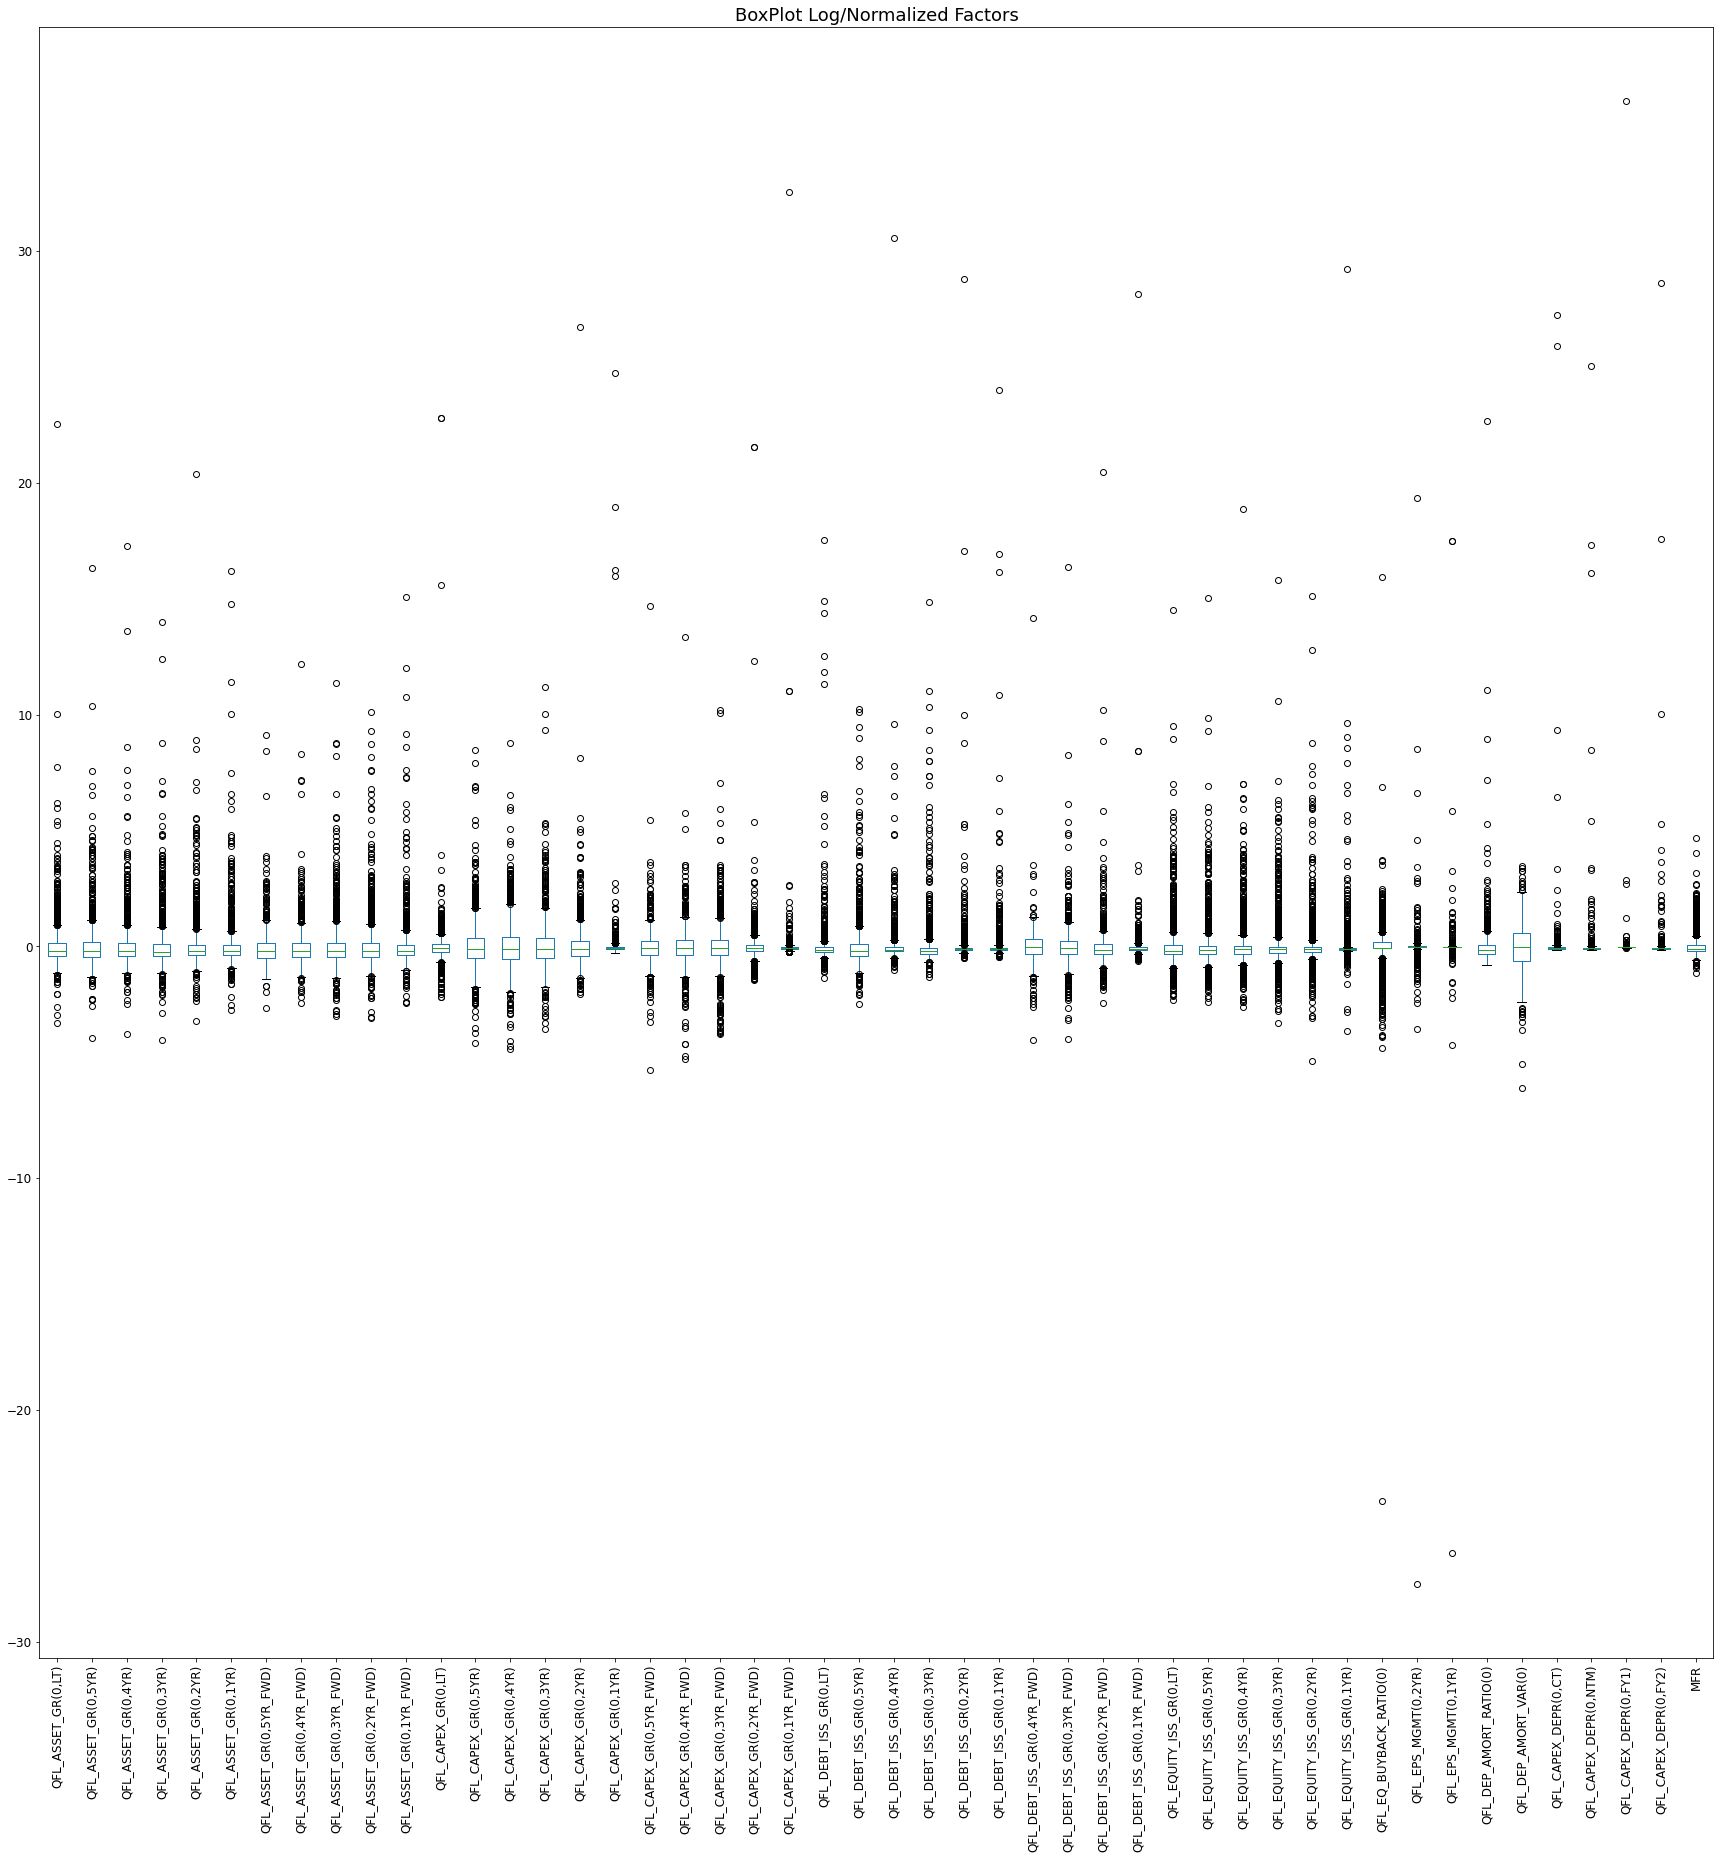

In [85]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [86]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,5YR)","QFL_ASSET_GR(0,4YR)","QFL_ASSET_GR(0,3YR)","QFL_ASSET_GR(0,2YR)","QFL_ASSET_GR(0,1YR)","QFL_ASSET_GR(0,5YR_FWD)","QFL_ASSET_GR(0,4YR_FWD)","QFL_ASSET_GR(0,3YR_FWD)","QFL_ASSET_GR(0,2YR_FWD)","QFL_ASSET_GR(0,1YR_FWD)","QFL_CAPEX_GR(0,LT)","QFL_CAPEX_GR(0,5YR)","QFL_CAPEX_GR(0,4YR)","QFL_CAPEX_GR(0,3YR)","QFL_CAPEX_GR(0,2YR)","QFL_CAPEX_GR(0,1YR)","QFL_CAPEX_GR(0,5YR_FWD)","QFL_CAPEX_GR(0,4YR_FWD)","QFL_CAPEX_GR(0,3YR_FWD)","QFL_CAPEX_GR(0,2YR_FWD)","QFL_CAPEX_GR(0,1YR_FWD)","QFL_DEBT_ISS_GR(0,LT)","QFL_DEBT_ISS_GR(0,5YR)","QFL_DEBT_ISS_GR(0,4YR)","QFL_DEBT_ISS_GR(0,3YR)","QFL_DEBT_ISS_GR(0,2YR)","QFL_DEBT_ISS_GR(0,1YR)","QFL_DEBT_ISS_GR(0,5YR_FWD)","QFL_DEBT_ISS_GR(0,4YR_FWD)","QFL_DEBT_ISS_GR(0,3YR_FWD)","QFL_DEBT_ISS_GR(0,2YR_FWD)","QFL_DEBT_ISS_GR(0,1YR_FWD)","QFL_EQUITY_ISS_GR(0,LT)","QFL_EQUITY_ISS_GR(0,5YR)","QFL_EQUITY_ISS_GR(0,4YR)","QFL_EQUITY_ISS_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,2YR)","QFL_EQUITY_ISS_GR(0,1YR)",QFL_EQ_BUYBACK_RATIO(0),"QFL_EPS_MGMT(0,CT)","QFL_EPS_MGMT(0,5YR)","QFL_EPS_MGMT(0,4YR)","QFL_EPS_MGMT(0,3YR)","QFL_EPS_MGMT(0,2YR)","QFL_EPS_MGMT(0,1YR)",QFL_DEP_AMORT_RATIO(0),QFL_DEP_AMORT_VAR(0),"QFL_CAPEX_DEPR(0,CT)","QFL_CAPEX_DEPR(0,NTM)","QFL_CAPEX_DEPR(0,FY1)","QFL_CAPEX_DEPR(0,FY2)","QFL_GP_RD(0,CT)","QFL_GP_RD(0,FY1)","QFL_GP_RD(0,FY2)",QFL_SOE_OPER_INC(0),QFL_SOE_NI(0),ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,14.232402,1.695430,-1.707381,-6.487602,-6.769890,-6.166559,18.641983,16.383162,8.334882,0.674282,0.323057,-3.274627,-12.585688,-17.143047,-25.134813,-27.651560,-37.684650,0.067768,2.301311,9.811879,24.030650,50.918533,4.721322,11.385763,5.804861,0.231421,4.306352,12.432742,NaN,NaN,NaN,0.000000,0.000000,-5.634582,-5.634582,-5.999499,-6.356990,-5.954141,-4.802382,5.306195,6.001890,6.001890,6.226742,6.916022,6.811154,6.040931,NaN,NaN,0.661089,0.901729,0.902168,0.899589,NaN,NaN,NaN,NaN,NaN,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,10.506919,11.064434,8.155799,7.002950,8.520770,9.004652,NaN,NaN,10.148942,9.147401,8.306876,15.733818,21.386242,24.667858,20.944489,19.020473,51.222800,NaN,NaN,12.200121,16.039371,22.062477,5.252995,12.079012,-0.082612,-2.046847,-2.550513,-4.867434,NaN,NaN,0.106457,0.177492,0.355299,-0.819236,-0.819236,-0.591624,-0.664943,-0.862533,-0.942332,1.770622,1.638246,1.638246,1.411974,1.669562,1.236820,1.065230,8.056472,0.745058,1.360305,1.593058,1.622348,1.557732,NaN,NaN,NaN,NaN,NaN,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,25.321291,38.589787,39.131737,34.145237,36.652040,39.623760,21.917560,22.079683,22.007670,25.596766,33.420467,20.962788,45.255684,43.213417,41.731430,78.630830,127.306010,14.852304,21.782967,27.358932,42.731700,111.827660,25.551268,47.610428,50.443413,34.597755,39.550900,30.370104,NaN,NaN,8.919565,17.703426,40.639690,1.408195,1.408195,1.418483,1.365161,1.279020,1.185274,0.000000,-2.608132,-2.608132,-2.378261,-1.907575,-1.069260,-1.884329,14.437173,1.400128,1.286771,0.974764,1.203026,0.957236,NaN,NaN,NaN,NaN,NaN,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,19.940973,26.453436,25.269270,24.391794,26.472950,16.051388,18.270350,19.277893,22.169395,22.172838,19.467426,16.395721,44.034256,37.877083,18.353440,-3.090429,-5.590177,9.230174,11.677859,15.541223,17.412542,4.697917,72.560680,72.560680,121.162674,886.410030,667.699800,12.734282,NaN,NaN,NaN,NaN,NaN,-0.173599,-0.173599,-0.566298,-0.689107,-0.212008,-0.145960,1.057473,0.007308,0.007308,0.345075,1.239991,1.092124,-0.020278,7.894865,0.795314,2.257925,2.459521,2.283508,2.472958,NaN,NaN,NaN,NaN,NaN,1
4,890100,30-Nov-202

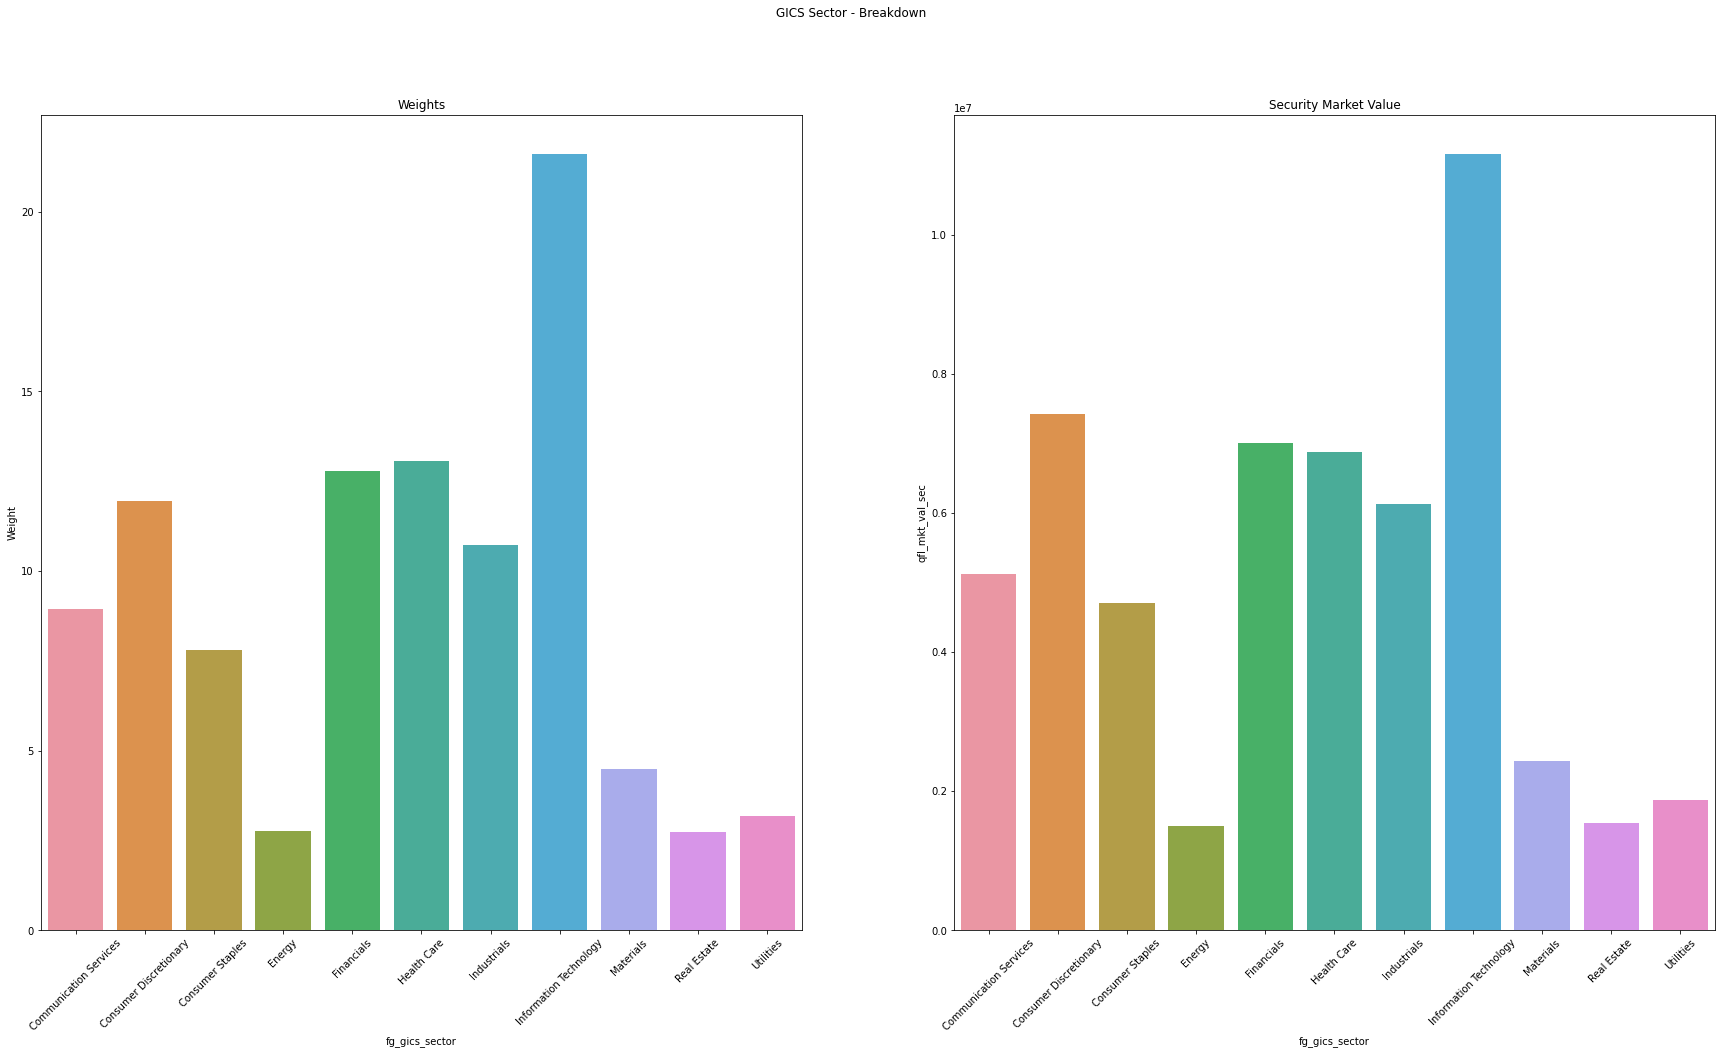

In [87]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

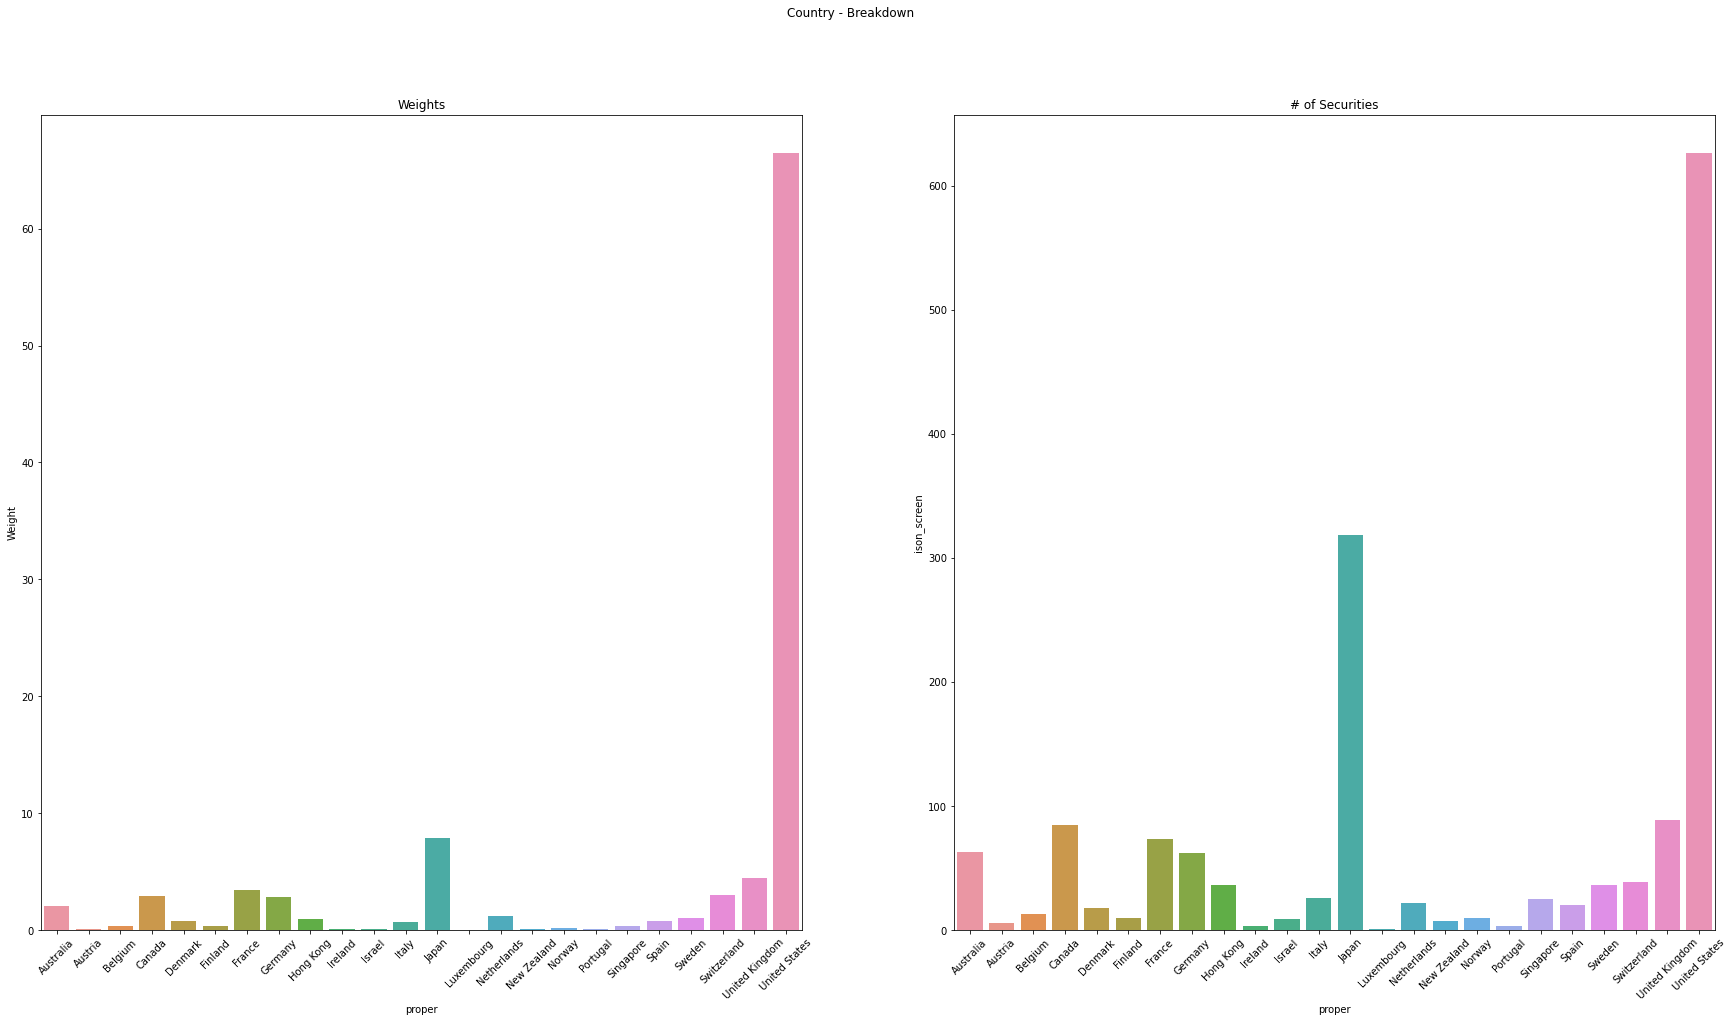

In [88]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

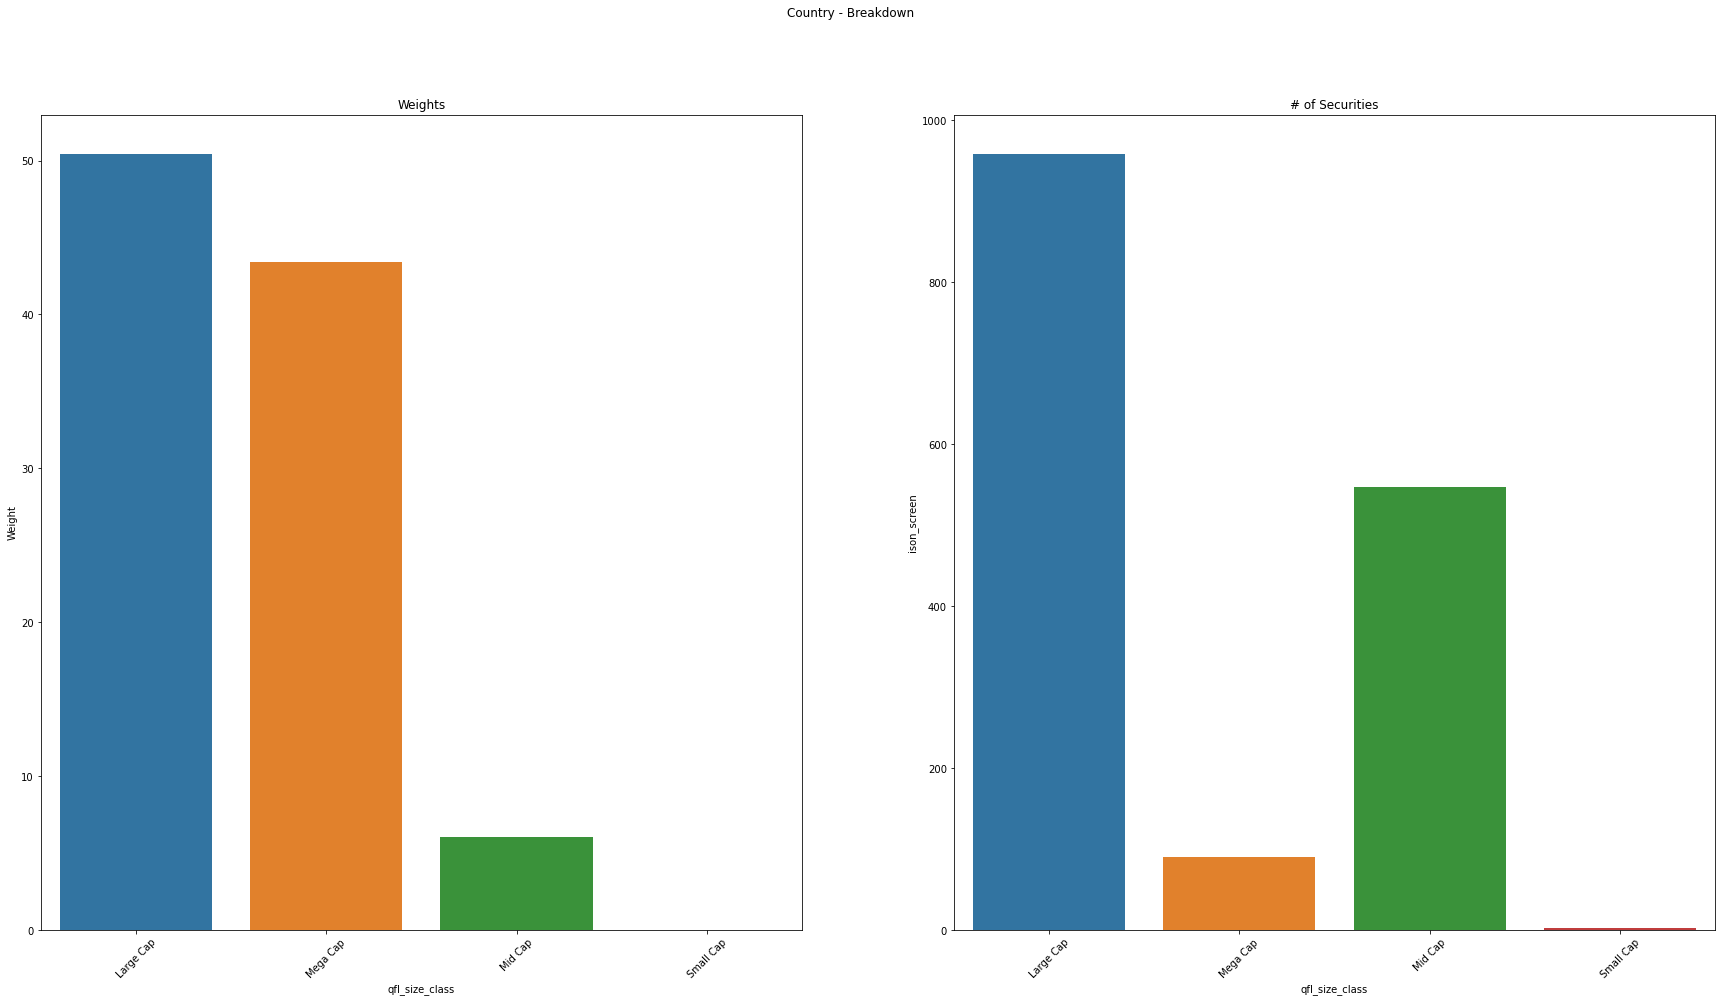

In [89]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [90]:
# Feature Selection

In [91]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [92]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-92-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [93]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [ True False False  True False False False False False False False False
 False False False False False False  True False False False False]
Feature Ranking: [ 1  3 17  1  7  5  4 14 13 18 11 10  6  8  9 12 15 16  1  2 19 20 21]


In [94]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_ASSET_GR(0,LT)', 'QFL_ASSET_GR(0,3YR)',
       'QFL_EQUITY_ISS_GR(0,3YR)'],
      dtype='object')

In [95]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,3YR)"
"QFL_ASSET_GR(0,LT)",1.000000,0.775639,0.414064
"QFL_ASSET_GR(0,3YR)",0.775639,1.000000,0.586856
"QFL_EQUITY_ISS_GR(0,3YR)",0.414064,0.586856,1.000000


In [96]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,3YR)"
0,14.232402,-6.487602,-6.356990
1,10.506919,7.002950,-0.664943
2,25.321291,34.145237,1.365161
3,19.940973,24.391794,-0.689107
4,14.715008,16.161573,-0.863880
...,...,...,...
1595,3.317663,2.025211,3.331697
1596,2.390451,4.987538,-0.506794
1597,0.316402,-1.894361,-5.940616
1598,1.678452,6.511712,0.000000


In [97]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_ASSET_GR(0,LT)","QFL_ASSET_GR(0,3YR)","QFL_EQUITY_ISS_GR(0,3YR)",MFR
0,0.612112,-0.833952,-1.170656,-0.464165
1,0.284338,-0.158475,-0.224617,-0.032918
2,1.587732,1.200548,0.112793,0.967025
3,1.114362,0.712190,-0.228634,0.532640
4,0.654573,0.300100,-0.257681,0.232331


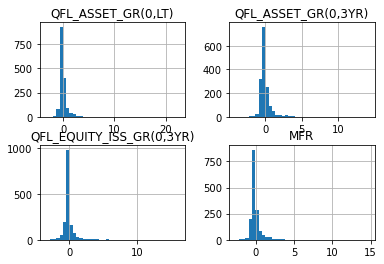

In [98]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [99]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.03
Information Coefficient (P-Value): 0.31


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [100]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.03
Information Coefficient (P-Value): 0.31


### Z-Score + Log-Transformation (All Components)

In [101]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: 0.01
Information Coefficient (P-Value): 0.82


### Z-Score Only (All Components)

In [102]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
